# Self-consistent evaluation of summarization using LLMs

- Continued from first experiments with WikiHow in `llm-self-con-eval` and SAMSum in other notebook
- Using `Samsung/samsum` now rather than local copy
- Will run several examples
- Will save outputs after computing results

## Dataset

[https://huggingface.co/datasets/Samsung/samsum](https://huggingface.co/datasets/Samsung/samsum)

Notes:

- I am going to first check dataset to see the number of summary facts for each conversation. Ideally there are many with 4 or 5 as this seems to be the sweet spot to get visible curve.
- Then, for now, I will stick to "F = 5" or "F = 4" conversations, so that it's a fixed variable and doesn't add a confounding variable
- Also, this will allow to do statistics by binning results (for a given conversation) according to the "shape" of the evaluation curve obtained i.e. via count of ascents or derangements or whatever

## Model

- Code below with `"microsoft/Phi-3-mini-4k-instruct"` runs on GPU P100
- Using basic settings for Microsoft Phi-3 from: [https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md](https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md)

## Various other considerations

- Different models
- Different prompts: currently not doing templated/extraction prompt, free prompt seems to give desired format for outputs
- Improve parsing functions: 1) converting scores to ints from the completions 2) splitting components of gold dataset summary into individual summary facts

### Install/config

`py7zr` needed for SAMSum dataset:

In [1]:
!pip install py7zr

In [2]:
import time
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from itertools import combinations
from random import sample, seed

2024-07-06 18:21:53.070069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 18:21:53.070123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 18:21:53.071579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
seed(1729)
torch.random.manual_seed(0)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [4]:
#model_checkpoint = "microsoft/Phi-3-medium-4k-instruct"
model_checkpoint = "microsoft/Phi-3-mini-4k-instruct" # RUNS ON Kaggle GPU P100

model = AutoModelForCausalLM.from_pretrained(
    model_checkpoint, 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Temperature settings for experiments

- Set 0 for all experiments so far

In [5]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

# Set temperature to 0 for experiment
generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

# Dataset

- Using `https://huggingface.co/datasets/Samsung/samsum`



In [6]:
dataset_name = "Samsung/samsum"
ds = load_dataset("Samsung/samsum")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for Samsung/samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Samsung/samsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## Exploration of dataset

- As mentioned, I want to first see the statistics of "how many summary facts" there are per conversation
- Get this by measuring the length of the split summary

In [7]:
ds["train"][321] # look at single example with a few sentences in the "summary" field

{'id': '13865182',
 'dialogue': "Marion: What is the plan for tomorrow?\nMary: We want to hike a bit\nMarion: where?\nTim: in the Jandia Peninsula\nLiam: wanna join?\nMarion: I don't feel like walking tomorrow\nMarion: so we can just meet afterwards to eat something\nLiam: ok, but where?\nMarion: in Morro Jable?\nLiam: sounds good, not far from the path\nMarion: exactly \nMarion: what time do you want to start?\nLiam: around 12\nMarion: so you won't be done before 5\nTim: you think so?\nMarion: I'm sure, i've done all the paths on this island\nMary: hahaha, ok\nMarion: it's a very beautiful place, you'll love it\nMarion: and write me when you're done\nMary: ok",
 'summary': "Mary, Tim and Liam are hiking tomorrow in the Jandia Peninsula. They'll start at 12. Marion has done all the hikes on the island. She'll meet them later in Morro Jable. They will write her when they finish."}

In [16]:
import re

In [34]:
def add_number_of_summary_facts(example, split_str='.'):
    # get the summary
    summary = example['summary']
    # split into sentences
    #summary_sentences = [x.rstrip(' ').lstrip(' ').rstrip(' .') for x in summary.split(split_str) if x]
    #summary_sentences = [x for x in summary_sentences if x != '']
    # UPDATE - this is too messy and leads to splitting e.g. "I won 24.15 dollars"
    # so use regex, also rstrip the . from the very last sentence
    # TODO: improve regex, basically want to "split on periods unless they are immediately follow by a non space char"
    summary_sentences = re.split(r"\. ", summary)
    summary_sentences = [x for x in summary_sentences if x != ''] # NEED TO ADD THIS AS DATASET CONTAINS TABS AT END AND WEIRD STUFF ffs
    summary_sentences[-1] = summary_sentences[-1].rstrip('.')
    
    # find the length
    num_summary_facts = len(summary_sentences)
    
    example["num_summary_facts"] = num_summary_facts
    return example

In [35]:
augmented_ds = ds.map(add_number_of_summary_facts)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [36]:
augmented_ds["train"][321] # looking at the previous example, the number of summary facts should be 5

{'id': '13865182',
 'dialogue': "Marion: What is the plan for tomorrow?\nMary: We want to hike a bit\nMarion: where?\nTim: in the Jandia Peninsula\nLiam: wanna join?\nMarion: I don't feel like walking tomorrow\nMarion: so we can just meet afterwards to eat something\nLiam: ok, but where?\nMarion: in Morro Jable?\nLiam: sounds good, not far from the path\nMarion: exactly \nMarion: what time do you want to start?\nLiam: around 12\nMarion: so you won't be done before 5\nTim: you think so?\nMarion: I'm sure, i've done all the paths on this island\nMary: hahaha, ok\nMarion: it's a very beautiful place, you'll love it\nMarion: and write me when you're done\nMary: ok",
 'summary': "Mary, Tim and Liam are hiking tomorrow in the Jandia Peninsula. They'll start at 12. Marion has done all the hikes on the island. She'll meet them later in Morro Jable. They will write her when they finish.",
 'num_summary_facts': 5}

In [37]:
dsdf = augmented_ds["train"].to_pandas()

dsdf["num_summary_facts"].value_counts()

num_summary_facts
1    5531
2    5108
3    2596
4    1006
5     351
6     117
7      19
8       4
Name: count, dtype: int64

## Filtering/removing "coreferences" etc

As noted in previous notebook versions, many of the summaries are "bad" (for our purpose at least) because they contain **unnamed references** (don't know what the proper linguistics word is for this phenomenon).

Basically if you have something like: "Bob went to the shop. It was busy." then splitting into 2 individual sentences, the 2nd sentence doesn't make sense without the first.

- Can either fix every datapoint yourself (TODO: won't take too long if you select e.g. a fixed size 5/6/7 as there aren't that many samples really)

**As a quick start, I looked through the sentences with 5 summary facts and MANUALLY NOTED the first 10 which had the desired property of being "coreference-free" i.e. unambiguous when split into separate sentences.**

Note that:

- you need to be careful for names like "he/she said" when referring to a previous sentence
- but equally need to look out for stuff like "Then they/Also he/Therefore..."

In [38]:
# look at the 5 ones or maybe 6,7 if too many to search through
dsdf.loc[dsdf["num_summary_facts"] == 5]

,id,dialogue,summary,num_summary_facts
21,13828741,"Aria: You won't believe who I've just met!\r\nAria: Charlie Evans!\r\nMaverick: Oh God, I haven't seen him from ages!\r\nMaverick: How is he doing?\r\nAria: He's doing great. :)\r\nAria: He got married, he runs a small family business, which he is very passionate about and generally he seems to be a happy and fulfilled man. :)\r\nAria: Oh, and he has two absolutely adorable daughters. :)\r\nAria: It was so nice to meet him, he's such a sweet soul.\r\nMaverick: I’m glad to hear that. :)\r\nMaverick: Time flies so fast, doesn't it?\r\nAria: It does. :) Recently I’ve met Cooper Roy, I'm sure you remember him, I constantly talked about him back then in high school, because I had a huge crush on him. He’s changed a lot!\r\nAria: I barely recognized him!\r\nMaverick: I remember, how you and Kylie used to gossip about him all the time. :)\r\nAria: Well, we were madly in love with him.\r\nAria: Or at least we thought so. ;)\r\nMaverick: I sometimes miss those times.\r\nMaverick: Everything seemed to be easier, better and calmer back then.\r\nAria: The world wasn’t as crazy as it is now.\r\nAria: I feel like politics got crazier, people - more radical and hostile and economics - less predictable...\r\nMaverick: Me too...:(","Aria has just run into Charlie Evans. He is now married, with two daughters, and a family business. She has also met Cooper Roy from high school. She used to have a crush on him, now she almost didn't recognise him. Maverick and Aria miss the old times and think the world has changed for the worse.",5
30,13716573,"Ray: Hey guys, I don't know if you heard but someone stole my bike yesterday so I'm going to post it on fb and would appreciate if you share! THX\r\nSam: shit, man, sorry to hear, I will share for sure\r\nLuke: when was it, Ray? I had mine stolen last month around when I parked around on the 9th street\r\nRay: Mine was there too :( cops said it's a common area for it to happen but I still havent lost hope :(\r\nScott: Did they check the security cameras around the place? Maybe Mariott people saw someone?\r\nRay: Apparently they don't overlook that area... \r\nLuke: Yeah, cops were completely useless too, I ended up going to Mariott on my own and asking people but they didn't see anything. I emailed their manager if they could look at the tapes but because of privacy issues blah blah blah it was a no go... Good luck man!\r\nRay: I mean those guys are pros... I had high grade lock on mine and an app alert and it didn't do shit. Now I'm out few grand and pissed off\r\nScott: I would be too. Did you post posters in the area? it's a busy street so maybe someone saw something\r\nRay: Yeah, I'm getting around to it now and I really hope that smeone was sober enough to notice anything. I mean it's a custom bike so I hope if they try to get rid of it it will rise suspicion\r\nLuke: I think it might ve already been turned into parts and shipped off. Even if you wanted to keep it and painted it, you could still recognize it\r\nRay: I know, that's why I wanna reach as many people as posible,maybe they ll get spooked and leave it somewhere\r\nSam: Let us know if you need someone to go dumpster diving with \r\nRay: Heh, thx Sam! I appreciate all help",Ray's bike was stolen from the 9th street yesterday even though it was secured. It was a custom bike so now Ray's out few grand. Ray wants to post posters in the area so they'll get scared and leave it somewhere. Luke had one stolen last month from the same area. Sam wants to help out.,5
40,13862359,"Andrea: hey Babes, how's it going? I've got some job to do. 20 short texts for an online shop. 50% for correction. Deadline in two weeks. Will you help me?\nSondra: Hi, sorry I don't think Im gonna make it. It is hard these days.\nAndrea: ?\nSondra: My cat is dying and nanny's leaving... :/\nAndrea: damn.. sorry to hear that. I f you could give me someone, maybe you know somebody suitable? I know aleady Jill can't do it :/\n

## Record list of ids identified as OK:

`[13730311, 13727936, 13611892, 13717228, 13729460, 13729449, 13829497, 13680384, 13611771, 13716568]`

**Note these are all of the same `dsdf.loc[dsdf["num_summary_facts"] == 5]` number of summary facts : 5**

**CARE! THEY ARE USING STRINGS RATHER THAN INTS FOR THEIR id FIELD >:(**

In [39]:
train_ids_manually_checked_ok = list(map(str, [13730311, 13727936, 13611892, 13717228, 13729460, 13729449, 13829497, 13680384, 13611771, 13716568]))

## Functions

- Made a quick "prompt template" function, avoid importing heavy frameworks etc.
- Split summary (a single sentence, string) into a list of `num_facts_in_summary` individual facts

### Prompt rationale / design decisions

- SAMSum has this in description of dataset construction : **Each dialogue was created by one person. After collecting all of the conversations, we asked language experts to annotate them with summaries, assuming that they should (1) be rather short, (2) extract important pieces of information, (3) include names of interlocutors, (4) be written in the third person. Each dialogue contains only one reference summary.** 
- So I will write a `get_samsum_prompt()` that prompts around this requirement

In [40]:
def get_samsum_prompt(samsum_text, curr_summary):
    
    samsum_system_prompt = "You are a helpful assistant who evaluates the quality of short summaries of conversations between 2 or more people."

    samsum_user_prompt = f"""Here is the full text of a internet chat conversation between 2 or more interlocutors. Each sentence in the conversation will begin with the corresponding interlocutor's name. The conversation is followed by a concise summary of the content of the conversation. Give a score, from 1 to 5, of the quality of the summary. If the summary extracts all of the essential information from the conversation, and correctly records the names of the interlocutors and their roles, give a score of 5. If the summary does not extract any information from the article, or if the summary makes factual mistakes, give a score of 1.

    ### Conversation Full Text ###
    {samsum_text}
    
    ### Conversation Summary ###
    {curr_summary}

    Give your answer in the following format, without deviation:

    Score: your score, an integer value between 1 and 5.
    Explanation: a short explanation of your Score.
    Missing Information: if your score is not 5, give the most important information that the summary missed from the conversation."""
    
    return samsum_system_prompt, samsum_user_prompt


def split_samsum_summary_for_combinations(summary: str, split_str='.'):
    summary_sentences = re.split(r"\. ", summary)
    summary_sentences = [x for x in summary_sentences if x != ''] # NEED TO ADD THIS AS DATASET CONTAINS TABS AT END AND WEIRD STUFF ffs
    summary_sentences[-1] = summary_sentences[-1].rstrip('.')

    return summary_sentences


def get_score_to_int(row):
    """
    Parse the "score" value from the row completion:

    Note that so far with Phi3 the prompt formatting is consistent so don't need to try/except stuff
    so just get the "number that is after Score: " basically O_o
    """
    # "Score: n......"
    # n is in index 7 <--- UPDATE IT IS IN 8!?!??! MAYBE DOUBLE SPACE I CAN'T SEE
    # TODO: make this safer/error handle O_o
    return int(row["completion"][8])

# Experiments


## Filter SAMSum dataset - filter on `train_ids_manually_checked_ok`

Do this once so can store and download a JSON file with the results from Kaggle

In [41]:
id_selector = set(train_ids_manually_checked_ok)

good_examples = augmented_ds["train"].filter(lambda example: example["id"] in id_selector)

Filter:   0%|          | 0/14732 [00:00<?, ? examples/s]

In [43]:
good_examples.to_pandas().head(10)

,id,dialogue,summary,num_summary_facts
0,13730311,"Monika: say hi to your new Facebook friend, Monika\r\nKeith: Hi, Monika.\r\nMonika: Hello. Do I know you from somewhere?\r\nKeith: Yes, you remember, I am Sophie's dad. Our kids were friends at school. \r\nMonika: Sophie from England?\r\nKeith: That's right, you do remember.\r\nMonika: I remember your Sophie punching my Paweł in the face, and me complaining to the school about it. How is she, anyway? Has she managed to stay out of prison?\r\nKeith: Yes, she is in Croatia now, for the holiday. She only punched him in the face because he was hitting her, by the way.\r\nMonika: Yes, but he was only hitting her because he liked her. But when she punched him back she broke his glasses, and you refused to pay for a new pair.\r\nKeith: That's right! So glad you remember us.","Monika's son Paweł and Keith's daughter Sophie were going to school together. Paweł used to hit Sophie, because he liked her. Sophie hit Paweł back once and broke his glasses. Keith refused to pay for Paweł's glasses. Sophie is in Croatia now for holidays.",5
1,13727936,"Tina: Hi love, you Ok?\r\nSally: Yep! Just got back from hols, had a great time, lovely weather too!\r\nTina: God, yes you have! Right in the middle of a heatwave, brilliant timing!\r\nSally: Yes, and unusual for a British summer! We had some lovely days out too.\r\nTina: Where'd you go?\r\nSally: Widemouth Bay, Sandymouth Bay, Cambourne, Bodmin Railway, Seaton Trams, PeccoRama.\r\nTina: Sounds like you did plenty!\r\nSally: Yes, we also had a few days around Bude, where there's a lovely second hand bookshops, pasties everywhere etc. Oh yes, and a rowing boat trip or two!\r\nTina: Oh, I love being out on the water!\r\nSally: We discovered we're not seafaring folk! We went on a pedalo boat first, I was too fat for it and we were front heavy, so I had to get out, nearly fell in in the process and had to crawl out on my stomach.\r\nTina: That must have looked funny!\r\nSally: Was a bit embarrassing! Next time, we tried a rowing boat, but we were hopeless at rowing! Then Mitch hit his head on the wooden seat and we had to go to the hospital as he felt so dizzy. Luckily, he didn't have concussion. Decided to give boats a miss after that.\r\nTina: No wonder! Still, lovely that you enjoyed it on the whole. Bye, love!\r\nSally: Bye! See you in the gym this week?\r\nTina: Hope to, I must get back to 2 or 3 times a week!\r\nSally: I know, me too! See you!","Sally came back from holiday. Summer is very warm in Britain this year. Sally visited a few different places, did a rowing boat trip and pedalo boat trip. Mitch hit his head on a wooden seat but did not have concussion. Sally wants to meet Tina in the gym next week.",5
2,13611892,"Anna: I am gonna kill Tom today.\r\nLisa: What happened?\r\nAnna: Can you imagine that he hasn't changed the baby's diaper for the whole day?\r\nLisa: Dear lord, no.\r\nAnna: Yes. the smell, the view when I finally changed Stevie - priceless\r\nLisa: Did you say something?\r\nAnna: Yes, I said: Are you fucking kidding me? Are you a complete idiot?\r\nLisa: And...?\r\nAnna: He said that a little pee never hurt anybody and that I'm overreacting\r\nLisa: Typical. Has he ever admitted that he screwed up?\r\nAnna: I honestly can't remember the last time he apologized to me. And it's getting really tiring, you know.\r\nLisa: I know, would you like Sam to talk to him? You know I can stir him into the right direction, he could really make him think\r\nAnna: I don't know... He's only gonna get mad.\r\nLisa: At Sam?\r\nAnna: At me.\r\nLisa: Oh, I see. Maybe you should try to talk to him, but like serious for once, not just in regards to you know, some one thing he messed up, but his general attitude.\r\nAnna: I know I should, but I am just so tired all the time, I get mad and then I just let it go.\r\nLisa: What do you say we leave Stevie with your sister and go to a SPA for a day during the weekend? A nice massage and a facial? Could 

# Prepare exportable results file

**I want to be able to save from Kaggle as hard to visualize and will do dataviz offline**

- Create a results JSON which has a `experiment_config` to track the model used, prompt used throughout, params etc
- Then in the `data` field, store all completions

### Copied prompts below as currently they are only in a function defined earlier

- This is just to save to a experiment results output file
- **TODO: deleted the f-string part, don't save the variables - check how you can save the {var_name_here} to JSON properly???**

In [56]:
samsum_system_prompt = "You are a helpful assistant who evaluates the quality of short summaries of conversations between 2 or more people."

samsum_user_prompt = f"""Here is the full text of a internet chat conversation between 2 or more interlocutors. Each sentence in the conversation will begin with the corresponding interlocutor's name. The conversation is followed by a concise summary of the content of the conversation. Give a score, from 1 to 5, of the quality of the summary. If the summary extracts all of the essential information from the conversation, and correctly records the names of the interlocutors and their roles, give a score of 5. If the summary does not extract any information from the article, or if the summary makes factual mistakes, give a score of 1.

### Conversation Full Text ###
_INSERT_FSTRING_VARIABLE_HERE_

### Conversation Summary ###
_INSERT_FSTRING_VARIABLE_HERE_

Give your answer in the following format, without deviation:

Score: your score, an integer value between 1 and 5.
Explanation: a short explanation of your Score.
Missing Information: if your score is not 5, give the most important information that the summary missed from the conversation."""

In [57]:
experiment_results = {
    "model_checkpoint": model_checkpoint,
    "generation_args": generation_args,
    "dataset_name": "Samsung/samsum",
    "prompts_used": {
        "system_prompt": samsum_system_prompt,
        "user_prompt": samsum_user_prompt
    },
    "experiments": []
}

experiment_results

{'model_checkpoint': 'microsoft/Phi-3-mini-4k-instruct',
 'generation_args': {'max_new_tokens': 600,
  'return_full_text': False,
  'temperature': 0.0,
  'do_sample': False},
 'dataset_name': 'Samsung/samsum',
 'prompts_used': {'system_prompt': 'You are a helpful assistant who evaluates the quality of short summaries of conversations between 2 or more people.',
  'user_prompt': "Here is the full text of a internet chat conversation between 2 or more interlocutors. Each sentence in the conversation will begin with the corresponding interlocutor's name. The conversation is followed by a concise summary of the content of the conversation. Give a score, from 1 to 5, of the quality of the summary. If the summary extracts all of the essential information from the conversation, and correctly records the names of the interlocutors and their roles, give a score of 5. If the summary does not extract any information from the article, or if the summary makes factual mistakes, give a score of 1.\n\

In [58]:
from copy import deepcopy

In [59]:
for samsum_example in good_examples:    
    print("**** EXPERIMENT WITH ****")
    print(samsum_example['dialogue'])
    print("***" * 30)
    
    num_summary_facts = samsum_example["num_summary_facts"]
    
    facts_from_summary = split_samsum_summary_for_combinations(samsum_example["summary"])
    
    # TODO: improve if need better performance when larger summaries
    num_facts_sampler = list(range(1, num_summary_facts + 1))
    
    curr_experiment = deepcopy(samsum_example)
    # save results to rows[] for later processing
    # will save to  curr_experiment["results"] after all combinations have been done
    rows = []

    start_time = time.time()

    for num_facts_to_include in num_facts_sampler:
        print(f"==== PROCESSING EXAMPLES CONSISTING OF : {num_facts_to_include} FACTS ====")
        
        
        # Generate all combinations of facts:
        all_combs = list(combinations(facts_from_summary, num_facts_to_include))
        
        # ... then sample from them, else will timeout O_o

        # TODO: improve, maybe take more combos for the intermediate values of 'k'
        number_of_combos_to_sample = min(len(all_combs), 2 * num_summary_facts)
        it = sample(all_combs, number_of_combos_to_sample)

        for selected_facts in it:
            # produce the article summary from these selected_facts
            # currently join with '. ' so that format is same as original SAMSum dataset
            JOIN_CHAR_SAMSUM = '. '
            curr_summary = JOIN_CHAR_SAMSUM.join(selected_facts)
            curr_text = samsum_example["dialogue"]

            print("PROCESSING : ", curr_summary)

            # send this to model
            system_prompt, user_prompt = get_samsum_prompt(curr_text, curr_summary)
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            res = pipe(messages, **generation_args)

            rows.append({
                "example_index_in_dataset": samsum_example["id"],
                "num_facts": num_facts_to_include,
                "selected_facts": selected_facts,
                "completion": res[0]['generated_text'],
            })        

    end_time = time.time()
    
    curr_experiment["results"] = rows
    
    experiment_results["experiments"].append(curr_experiment)
    

print()
print("-----")
print("TOTAL TIME TAKEN FOR THIS EXAMPLE : ", end_time - start_time)
print("-----")
print()

**** EXPERIMENT WITH ****
Monika: say hi to your new Facebook friend, Monika
Keith: Hi, Monika.
Monika: Hello. Do I know you from somewhere?
Keith: Yes, you remember, I am Sophie's dad. Our kids were friends at school. 
Monika: Sophie from England?
Keith: That's right, you do remember.
Monika: I remember your Sophie punching my Paweł in the face, and me complaining to the school about it. How is she, anyway? Has she managed to stay out of prison?
Keith: Yes, she is in Croatia now, for the holiday. She only punched him in the face because he was hitting her, by the way.
Monika: Yes, but he was only hitting her because he liked her. But when she punched him back she broke his glasses, and you refused to pay for a new pair.
Keith: That's right! So glad you remember us.
******************************************************************************************
==== PROCESSING EXAMPLES CONSISTING OF : 1 FACTS ====
PROCESSING :  Sophie hit Paweł back once and broke his glasses
PROCESSING :  M

# Save and export results to json

- Will download from Kaggle also

In [60]:
import json

with open('final-llm-self-con-eval-10-samples-len-5.json', 'w') as fo:
    json.dump(experiment_results, fo, indent=4, ensure_ascii=True)

# Iterate over the 10 individual experiments and plot results

- For notebook here will do it without saving all to single dataframe and groupby
- Just iterate directly

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

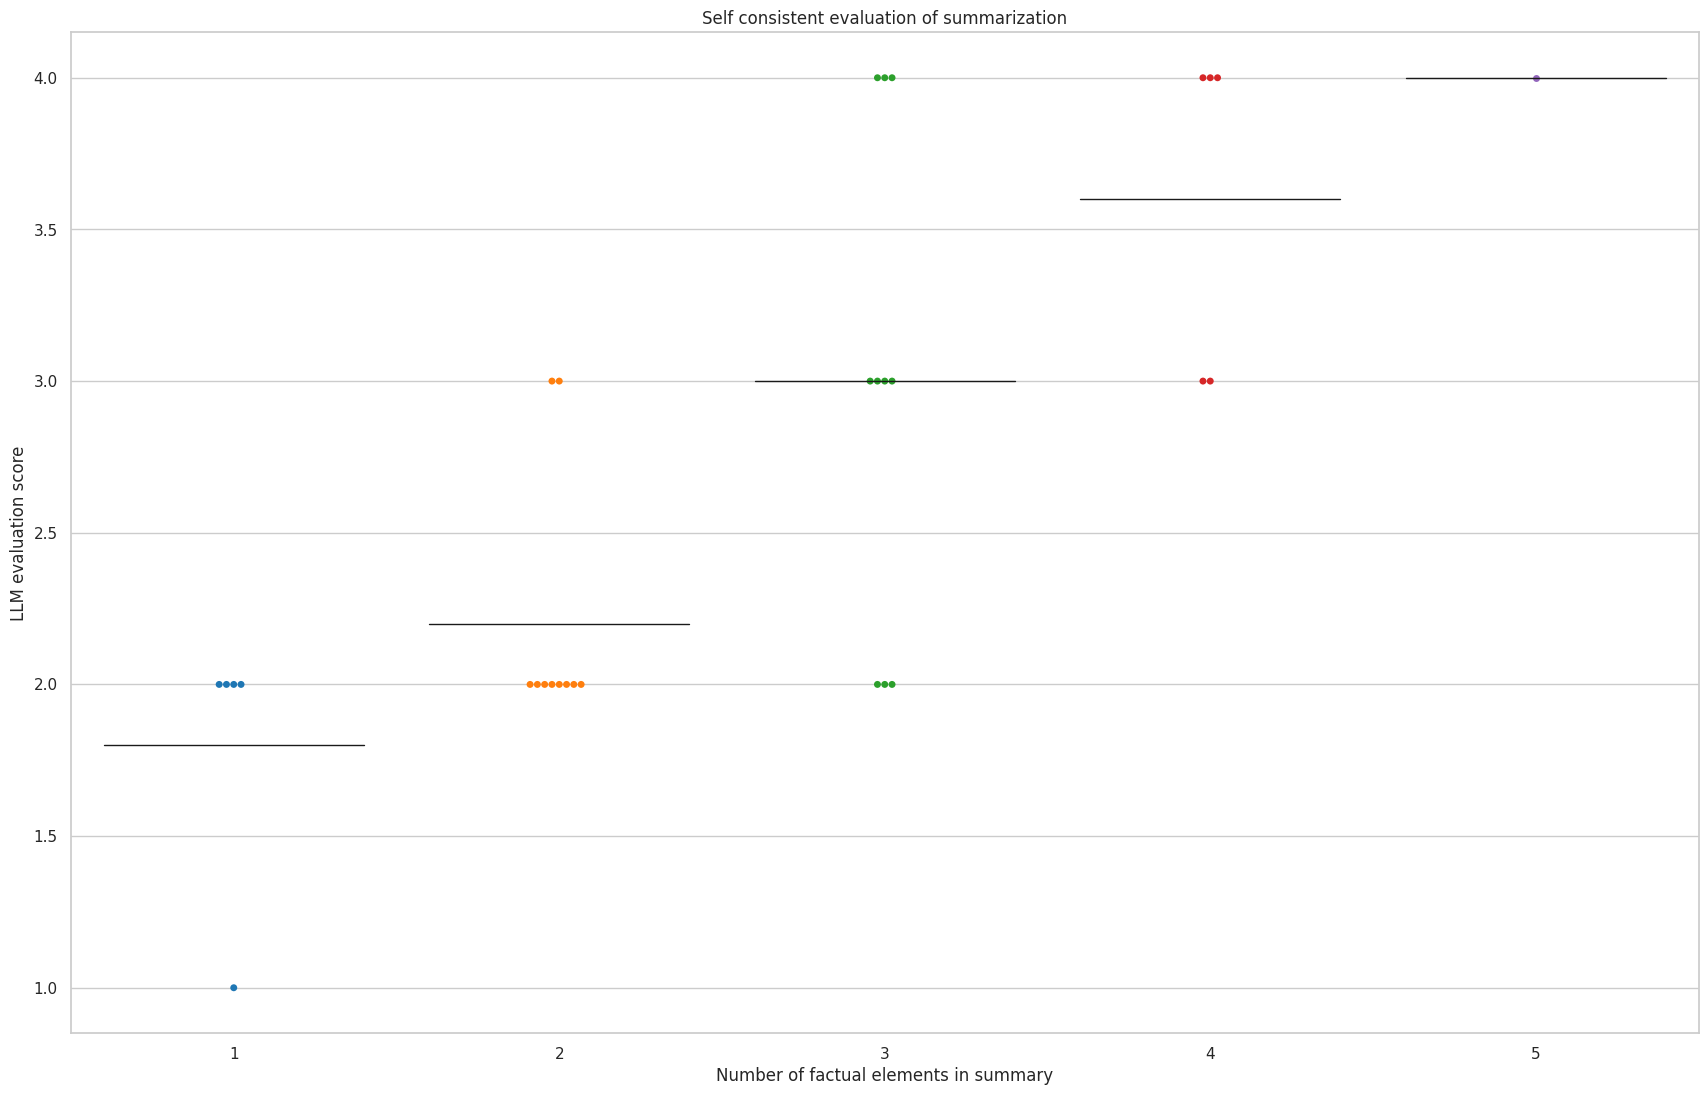

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

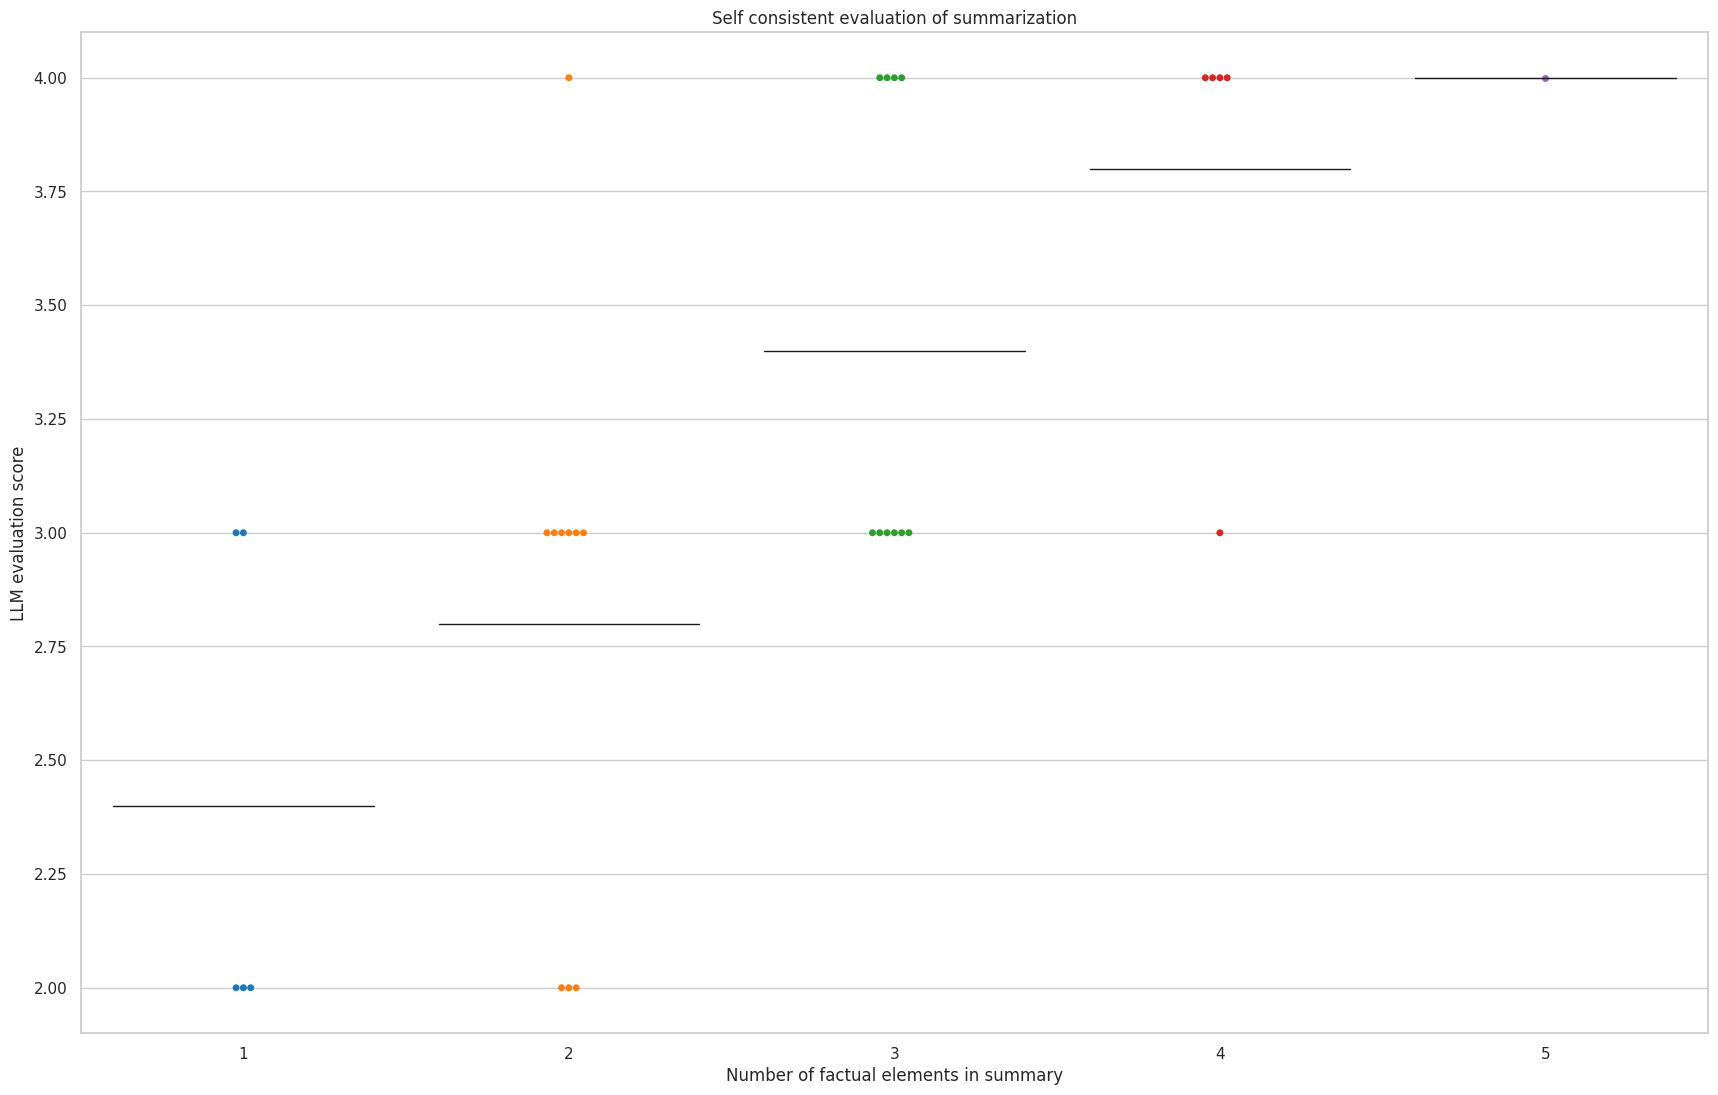

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

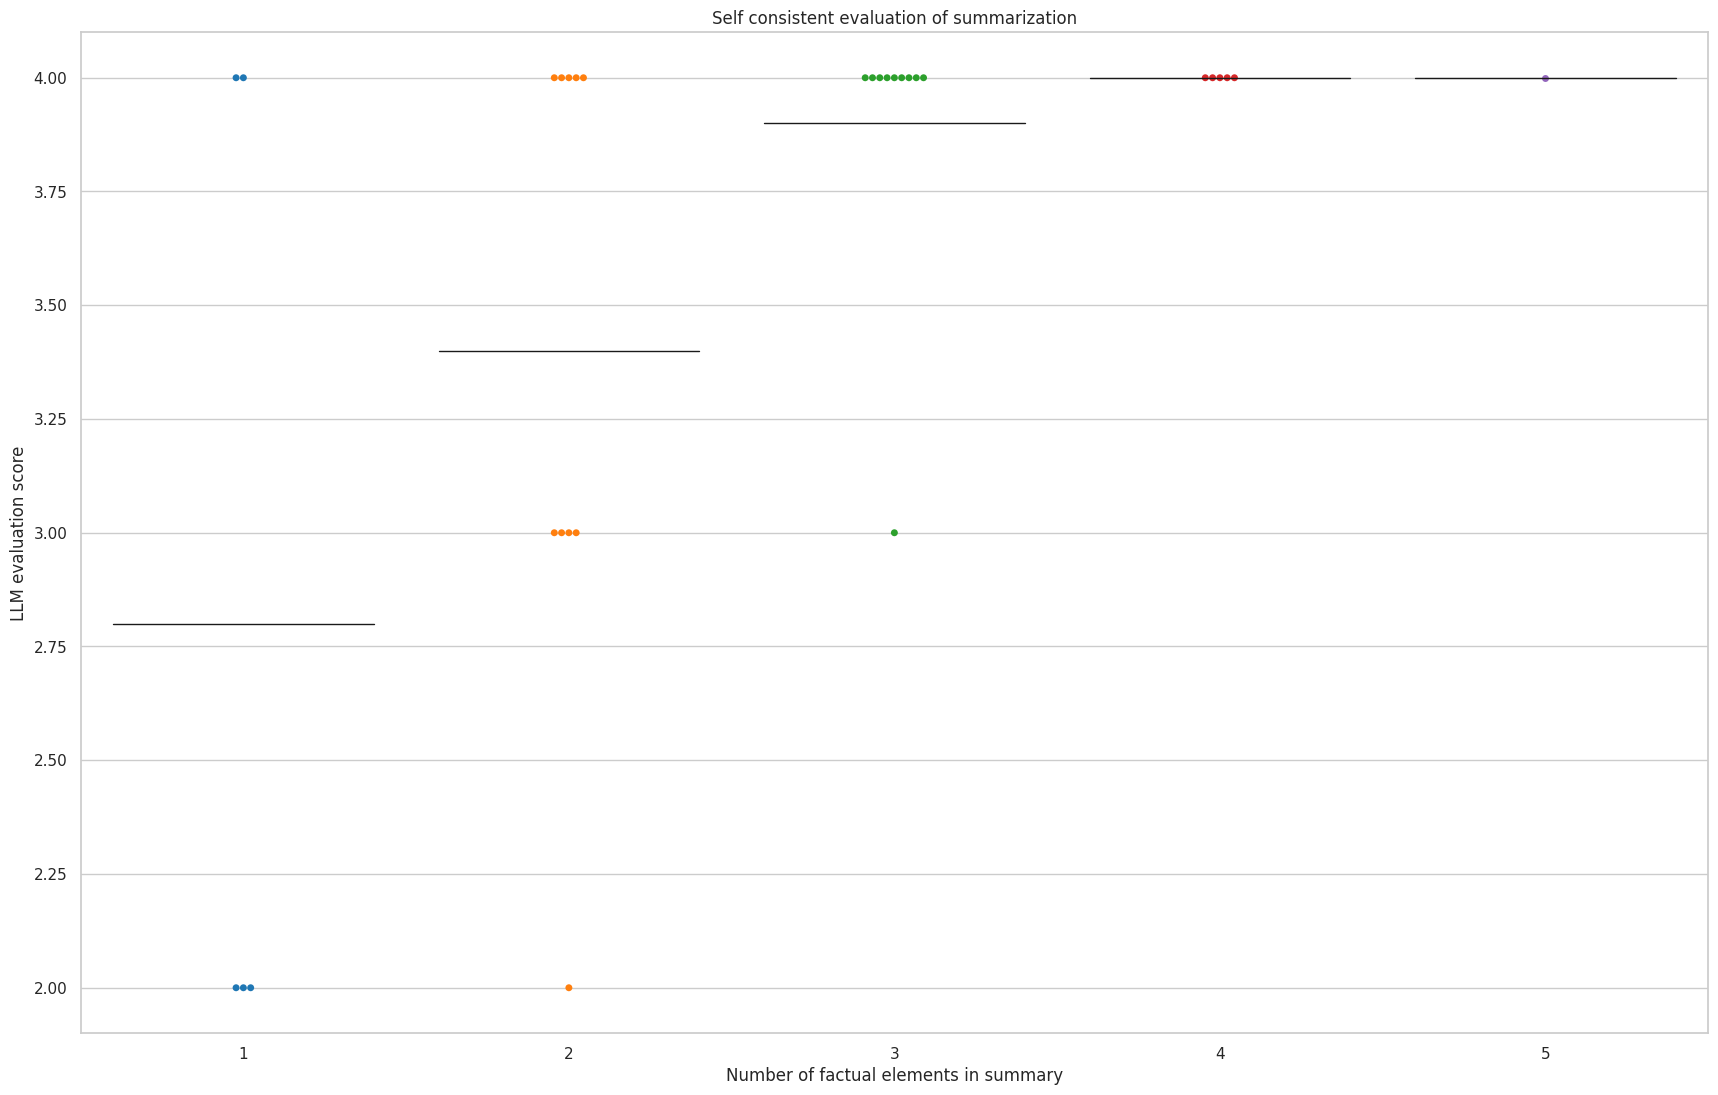

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

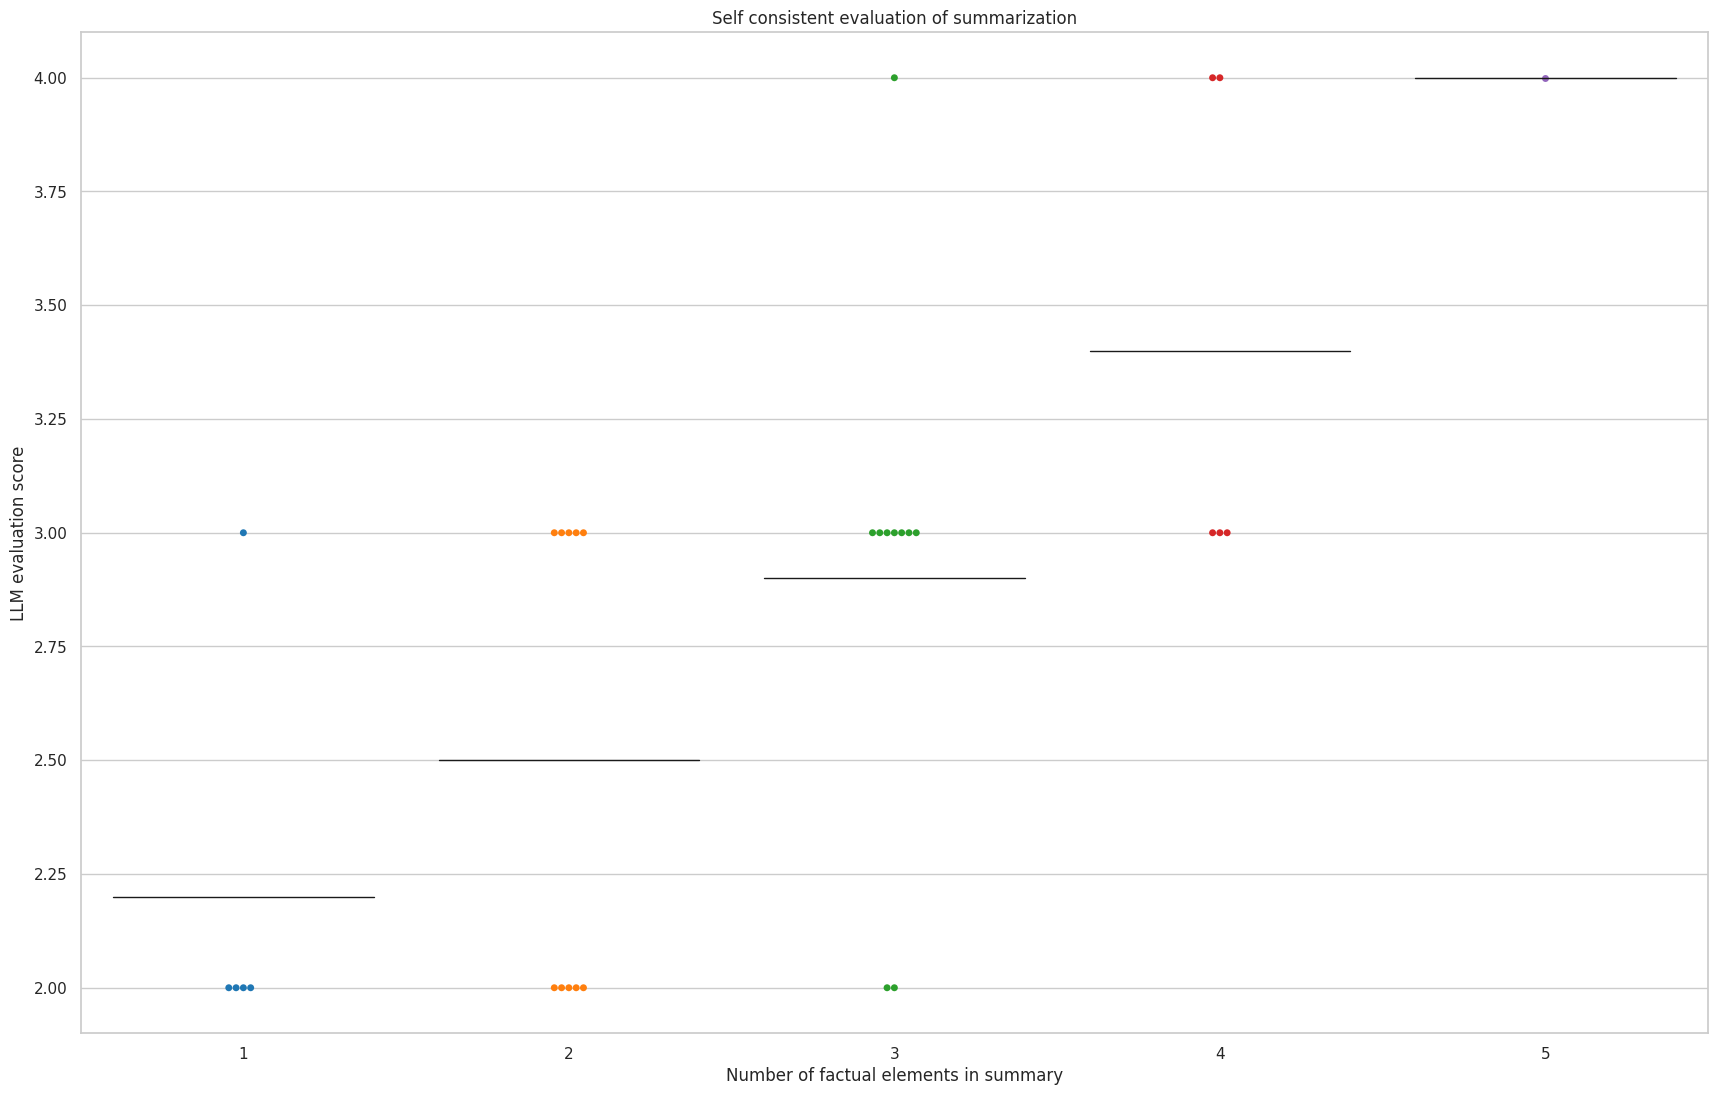

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

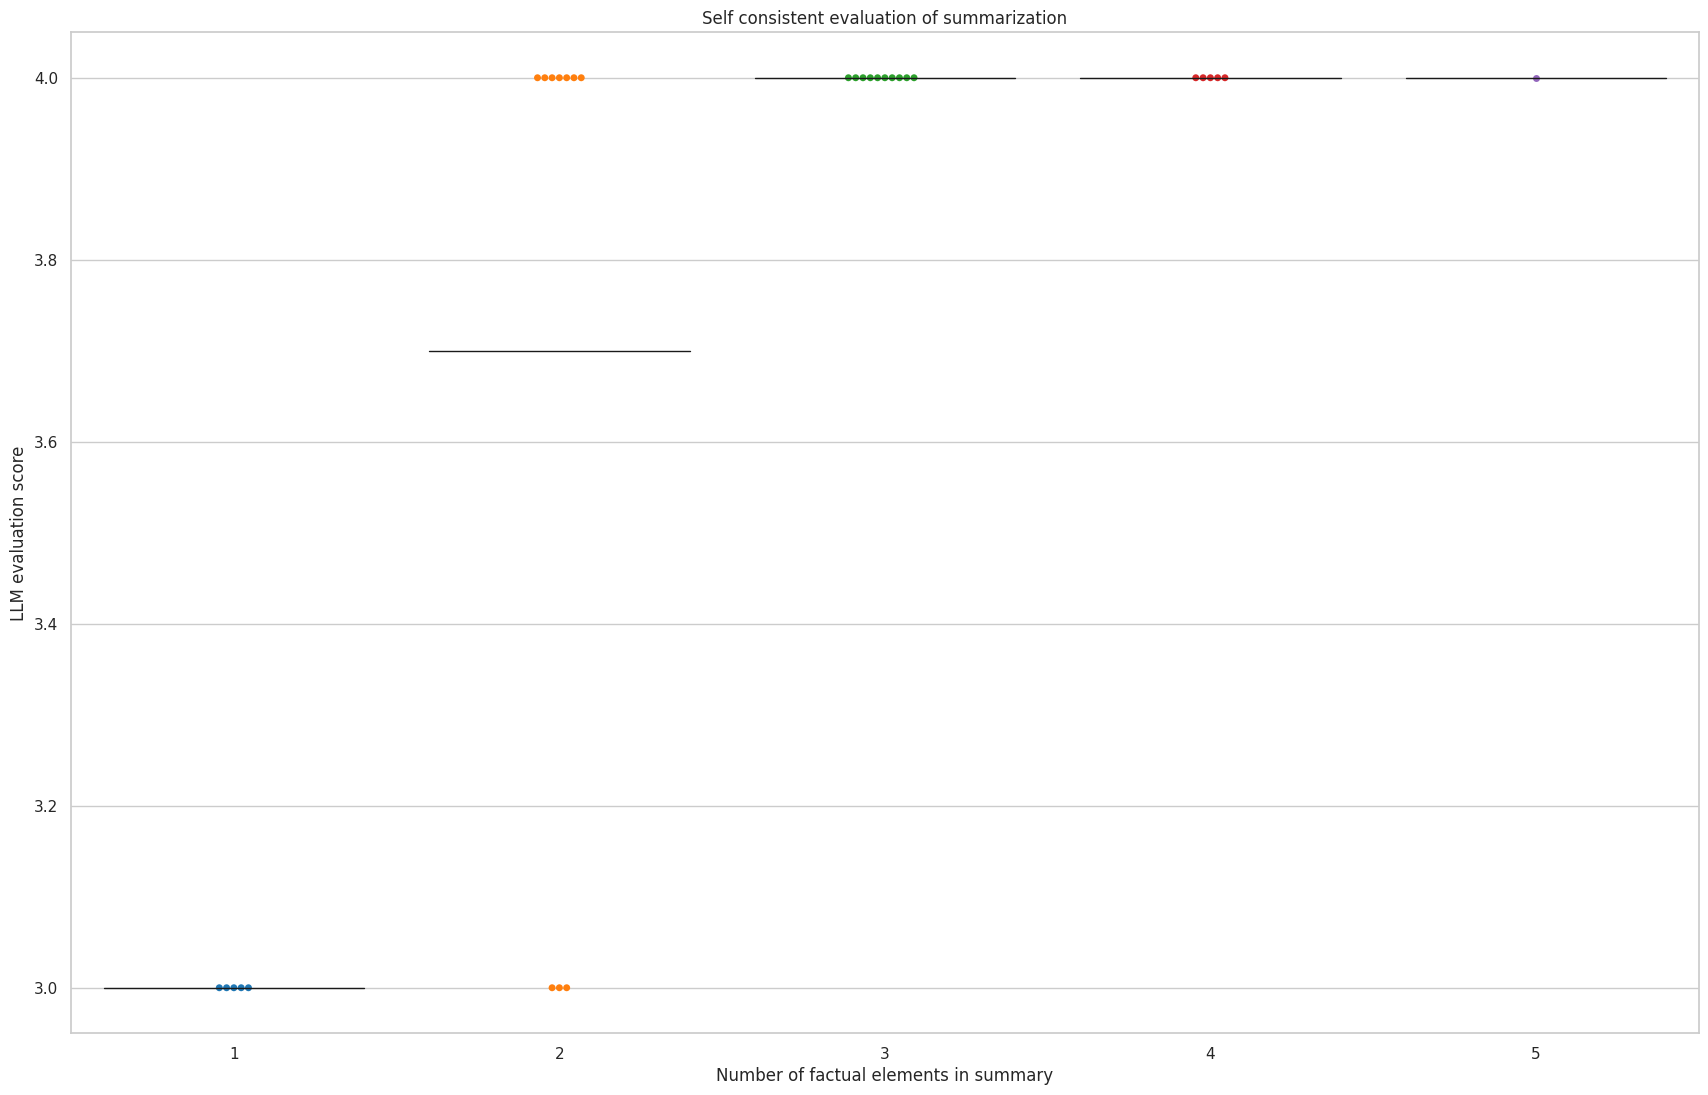

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

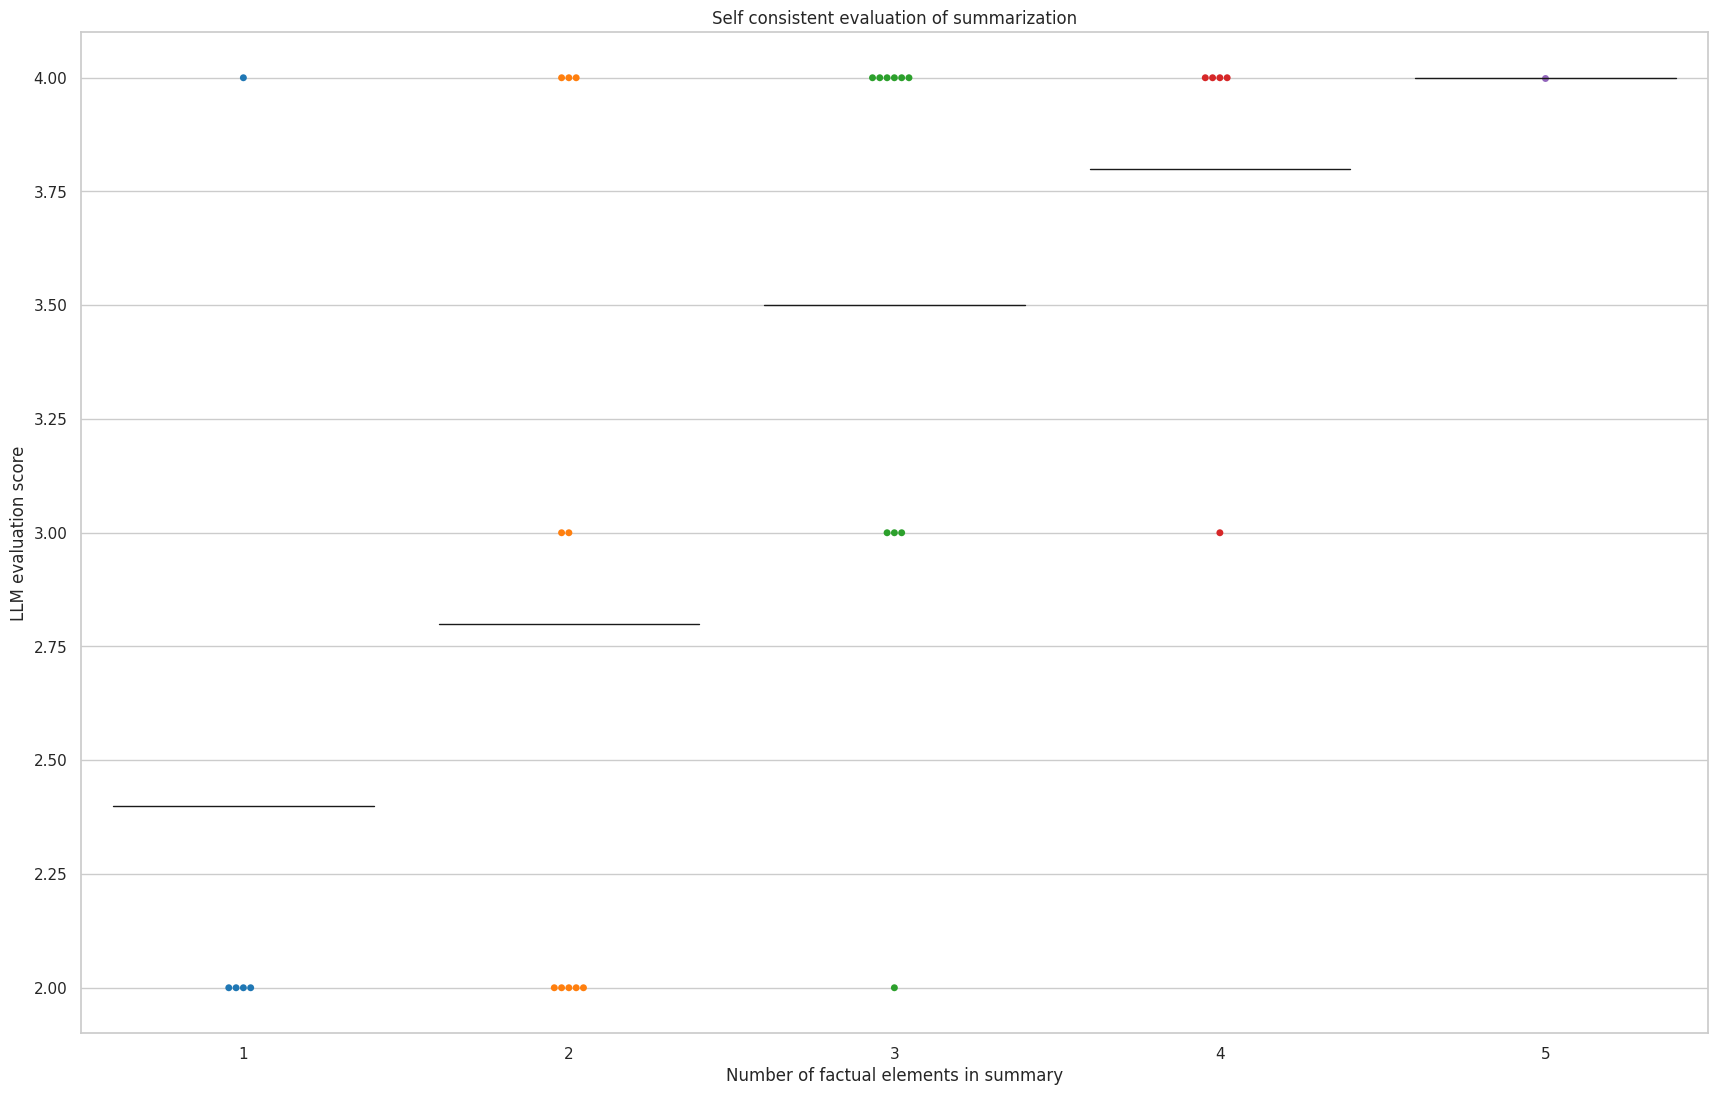

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

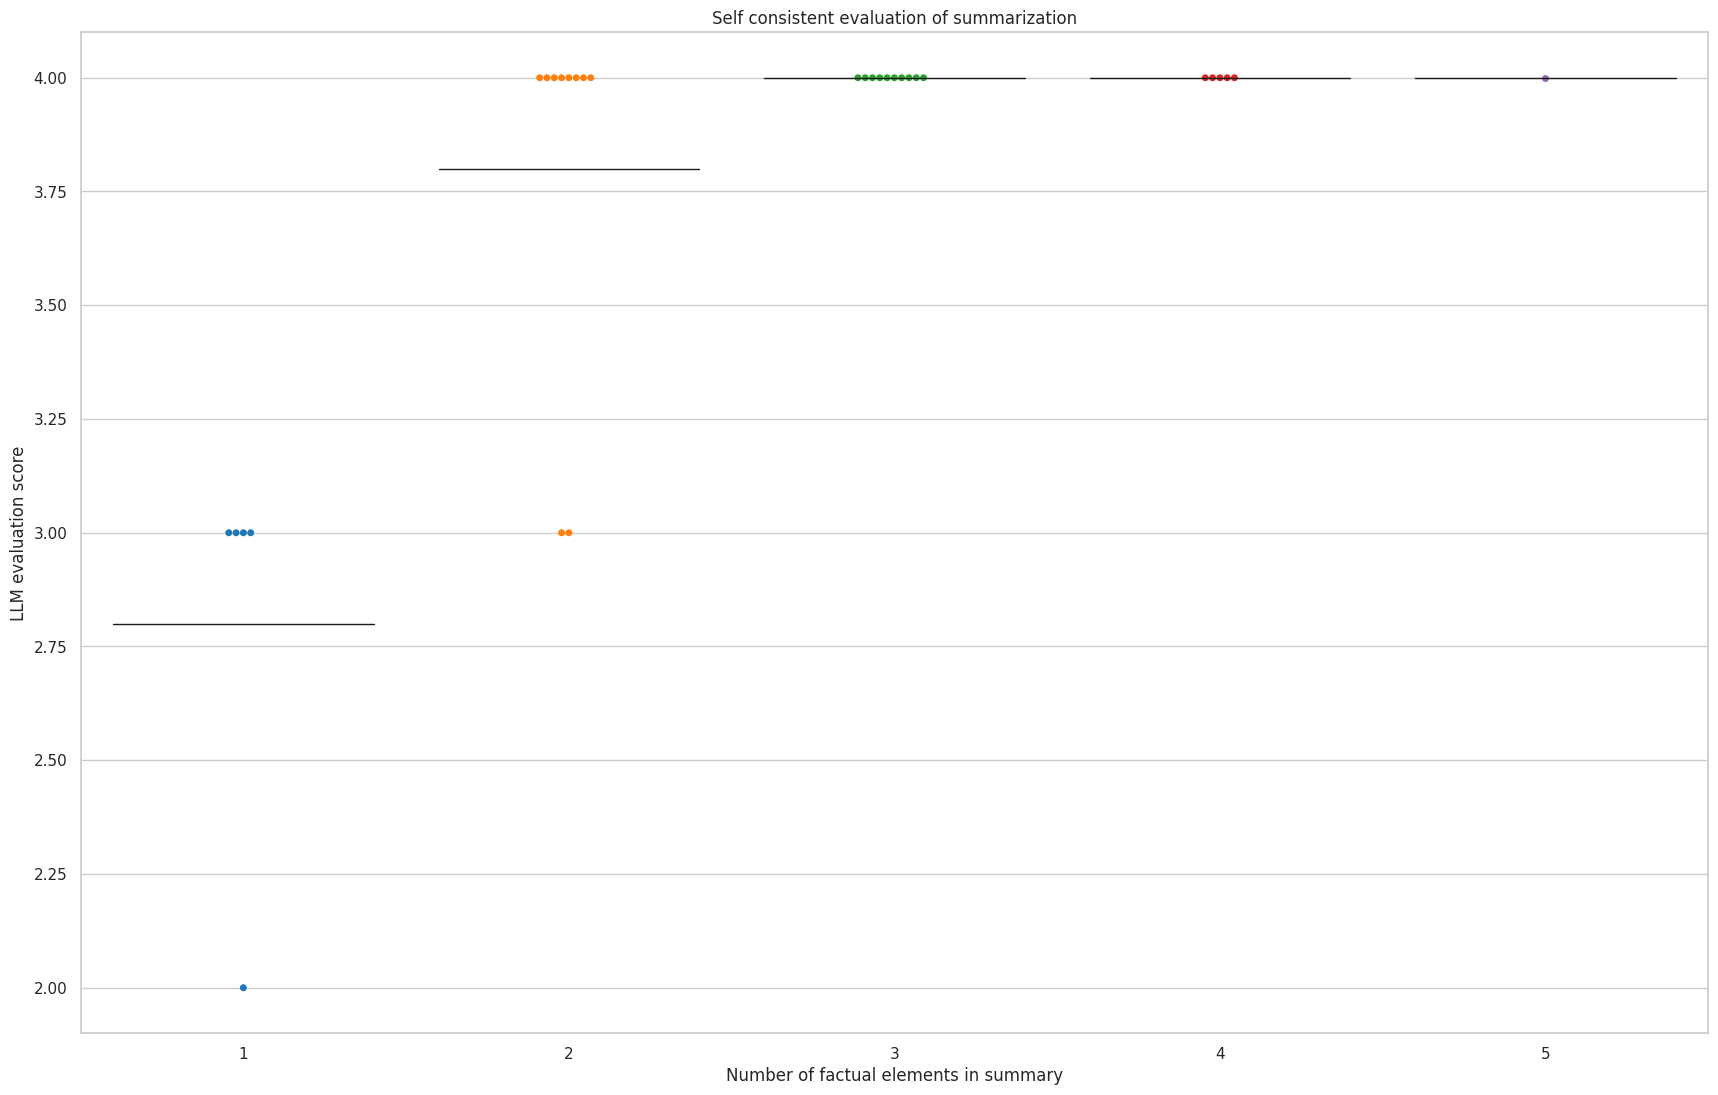

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

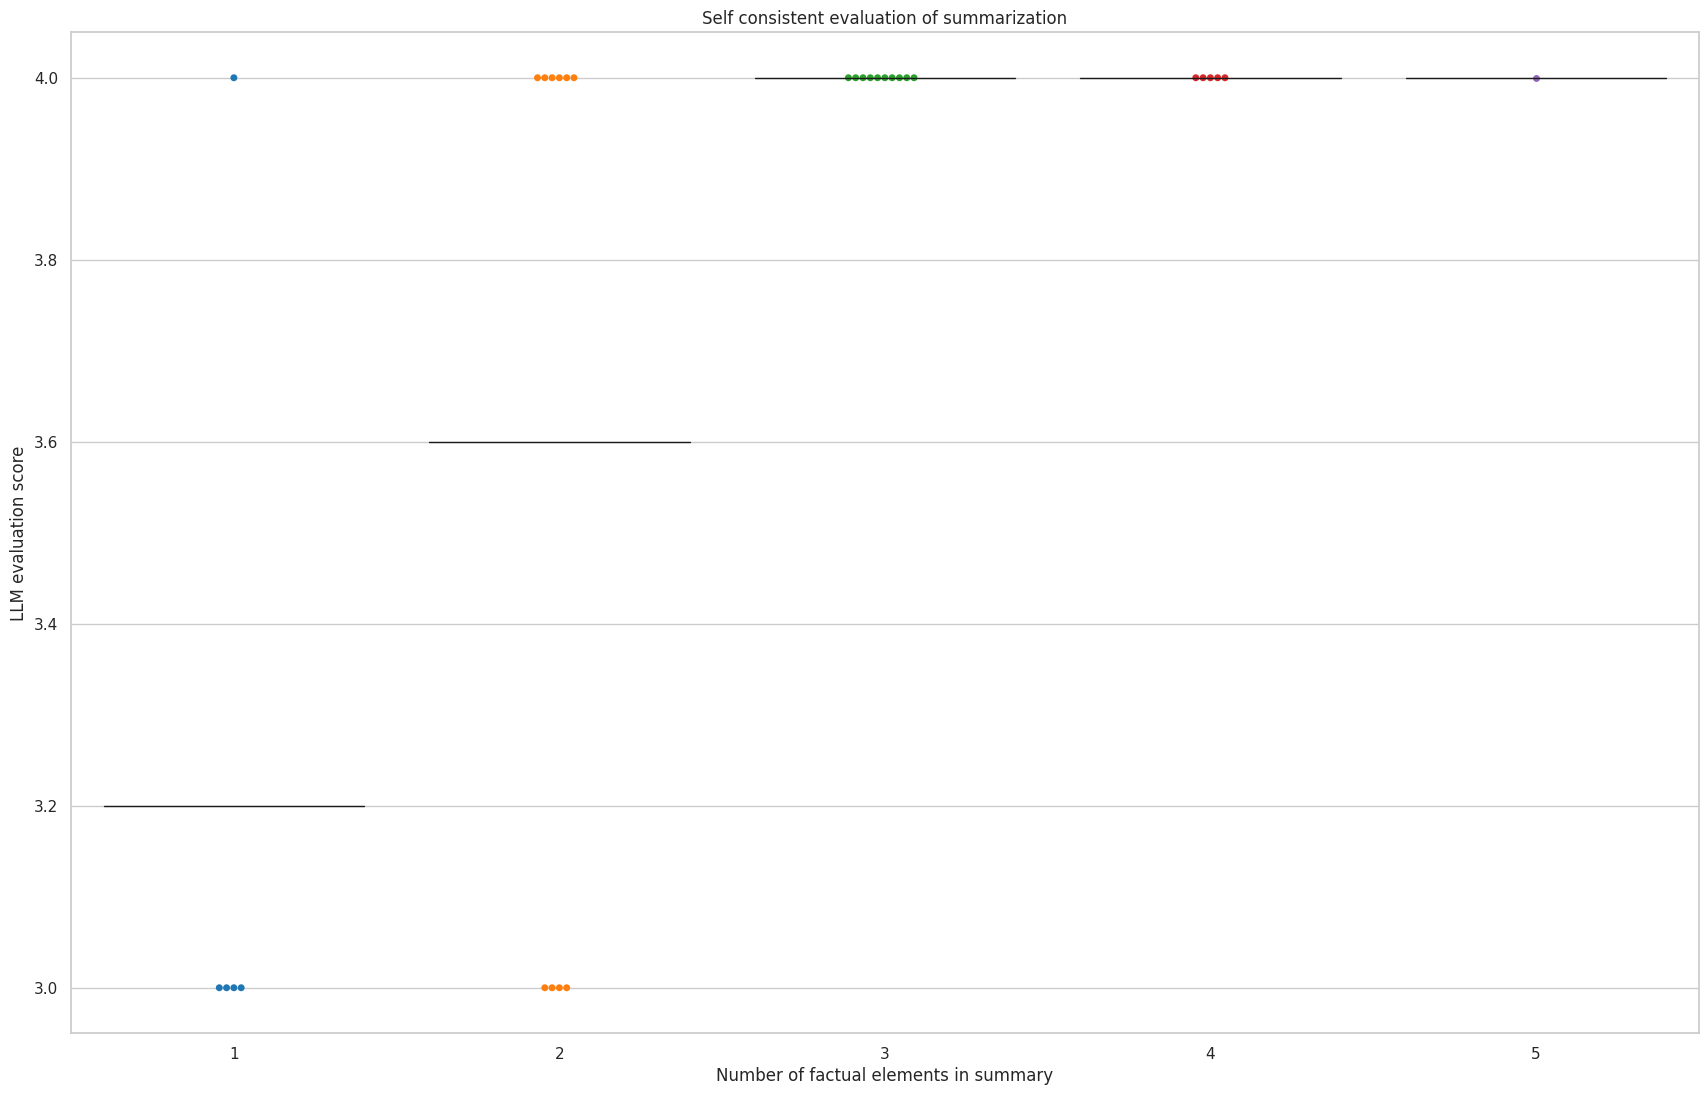

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

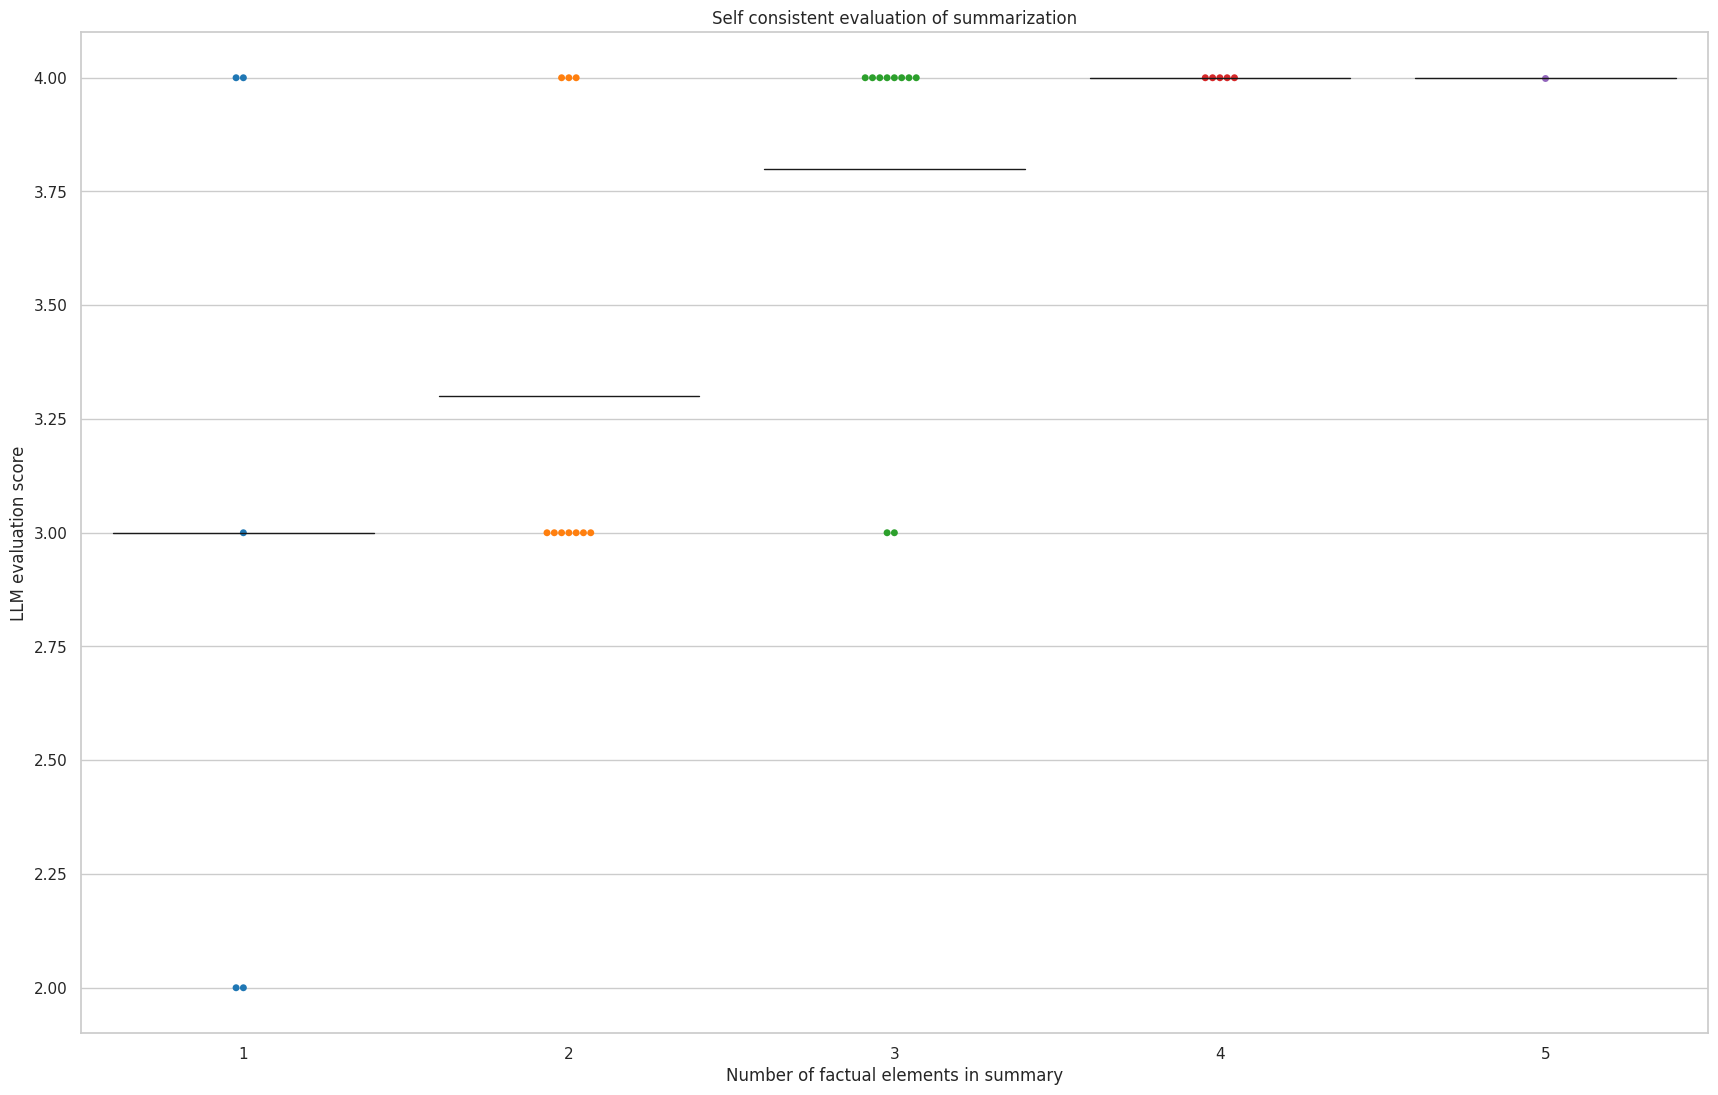

/tmp/ipykernel_808/3391935781.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

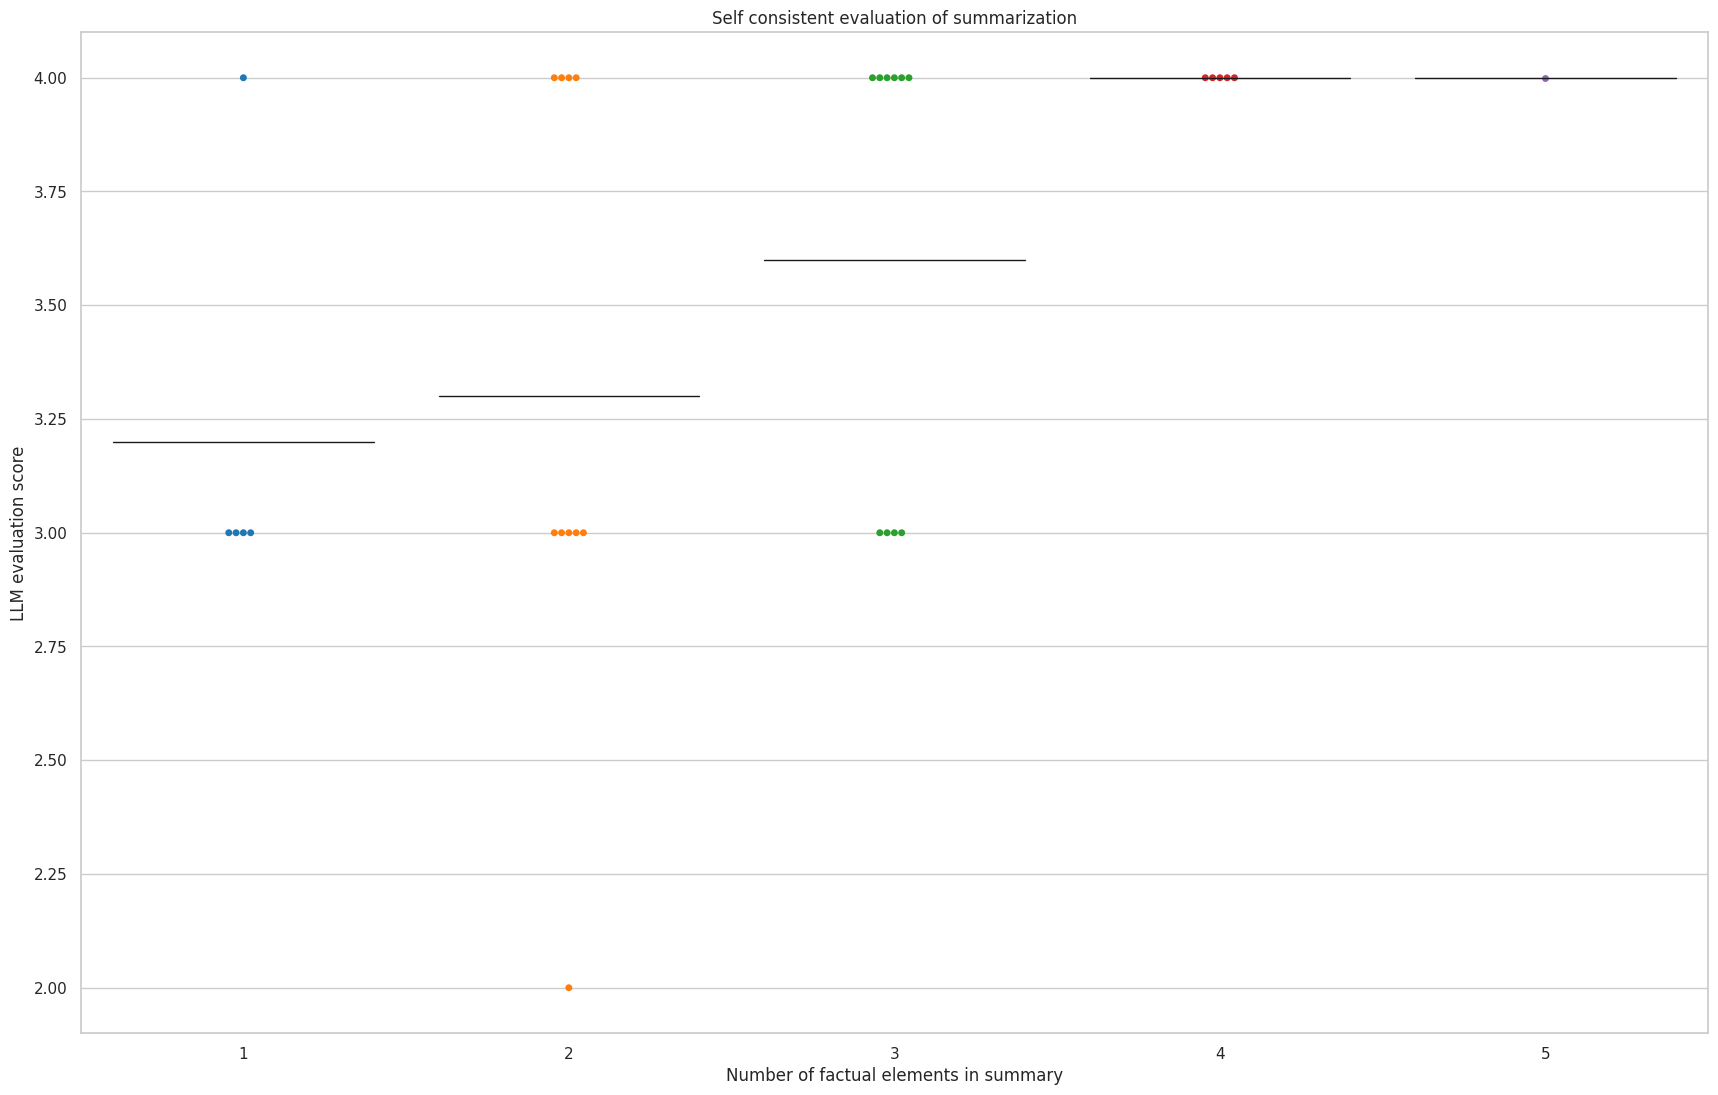

In [65]:
for experiment in experiment_results["experiments"]:
    df = pd.DataFrame(experiment["results"])
    df["score"] = df.apply(get_score_to_int, axis=1)
    simple_df = df[["num_facts", "score"]]
    #display(simple_df.head())
    sns.set(style='whitegrid')

    # Code from:
    # https://stackoverflow.com/questions/67481900/how-to-add-a-mean-line-to-a-seaborn-stripplot-or-swarmplot
    # note: need to adjust size if have more points else they don't fit in swarmplot O_o
    plt.figure(figsize=(21, 13))
    p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")

    ax=sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 1},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="num_facts",
                y="score",
                data=simple_df,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)

    plt.title('Self consistent evaluation of summarization')
    ax.set_ylabel("LLM evaluation score")
    ax.set_xlabel("Number of factual elements in summary")
    plt.show()

## Observations and ideas

As noted previously, it's important to see whether it is evaluating:

- factuality
- according to length

So need controls, for example, where you keep the same length but vary the factuality.

I am going to negate facts and swap people around: **can imagine doing this on a spectrum from subtle-errors to obvious-errors also**

## TODO: need to do this "formally" i.e. have an annotation scheme

For now I will do some combination of the follow operations:

- swap names/roles such that the resulting sentence is not true (but **same entities mentioned**)
- adjust numerical values
- adjust factual places/references etc

In [73]:
INCORRECT_AUG = {}

### Iterate over visually one by one and add incorrect version

In [70]:
it =  good_examples.to_pandas().iterrows()

In [71]:
next(it)

(0,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    13730311
 dialogue             Monika: say hi to your new Facebook friend, Monika\r\nKeith: Hi, Monika.\r\nMonika: Hello. Do I know you from somewhere?\r\nKeith: Yes, you remember, I am Sophie's dad. Our k

In [98]:
INCORRECT_AUG["13730311"] = "Monika's daughter Sophie and Keith's son Paweł were going to school together. Paweł used to hit Monika, because he liked her. Monika hit Paweł back once and broke his glasses. Keith refused to pay for Paweł's books. Sophie is in Slovakia now for holidays."

In [75]:
next(it)

(1,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [99]:
INCORRECT_AUG["13727936"] = "Tina came back from holiday. Summer is not very warm in Britain this year. Mitch visited a few different places, did a rowing boat trip and pedalo boat trip. Mitch hit his head on a wooden seat and got a concussion. Sally met Tina in the gym last week."

In [77]:
next(it)

(2,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [100]:
INCORRECT_AUG["13611892"] = "Anna is angry as Stevie hasn't changed Tom's diaper for the whole day. Lisa thinks Anna should kill Tom. Lisa and Anna went to a Spa last weekend. Lisa suggests leaving Stevie with Tom. Lisa will go to the Dream Spa today."

In [79]:
next(it)

(3,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [101]:
INCORRECT_AUG["13717228"] = "Janice wants to throw a baby shower for Agnes and suggests designer clothes as a gift. Kathy opts for more practical gifts so Ursula suggests a compromise. Kathy thinks her suggestion is better. Alice removed Agnes from the conversation. Ursula thinks it was mean but wants to move on."

In [81]:
next(it)

(4,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           13729460
 dialogue             Laura: Are you still coming to visit in December?\r\nKas: Looks like I can't make it as the other housemates are going home for Christmas :-(\r\nLaura: But you said that you would.\r\nKas: I know. It looks like I'll have to stay in

In [102]:
INCORRECT_AUG["13729460"] = "Kas is visiting Laura in December. Kas is going home for Christmas and Kas' housemates have to stay in the house. Laura has to work over Christmas. Kas was made to work more hours. Kas will have to find a new dog."

In [83]:
next(it)

(5,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [103]:
INCORRECT_AUG["13729449"] = "Heather's Dad will bring Peter dinner in half an hour. Lovey and Alistair are off nursery tomorrow. Twins are working tomorrow. Peter's mother passed away. Peter will visit Heather tomorrow afternoon and bring a cake. "

In [85]:
next(it)

(6,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [104]:
INCORRECT_AUG["13829497"] = "Vikki finished second in a competition. There was a two-point difference between Vikki and the girl immediately behind her in the score. Vikki received McDonalds as a prize. Vikki's waiting for Leonor to pick her up in McDonald's. Vikki will leave food for Leonor to microwave."

In [87]:
next(it)

(7,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           13680384
 dialogue             Pearl: How you doing, love?\r\nStephen: Hello Auntie. It's lovely to hear from you! How's Spain?\r\nPearl: Absolutely divine darling! I've got a new man as well!\r\nStephen: Another o

In [105]:
INCORRECT_AUG["13680384"] = "Pearl - Stephen's aunt - is in Spain and can't stand it. Vince has a new partner named Stephen. Will comes to Spain every year like Pearl. Stephen's sister disapproves of Pearl's lifestyle. Pearl and Auntie will see each other at Christmas."

In [89]:
next(it)

(8,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [106]:
INCORRECT_AUG["13611771"] = "Anna is a Senior Recruitment Consultant from TCG World, which is looking for Polish interpreter/translators. Monica is interested in positions with Spanish and English as a second language. Monica sent her CV to Anna. Anna wants to earn around 1000 eur/day. Anna has a notice period."

In [91]:
next(it)

(9,
 id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [107]:
INCORRECT_AUG["13716568"] = "Mr. Benson will cancel his day off on Mark's request. Claudia will call out major clients to ask about their workload and provide data by 10:30. Mr. Benson will prepare a presentation on the company byt the end of the day. Mark will do data mining on Andy's presentation."

In [96]:
next(it)

StopIteration: 

In [108]:
INCORRECT_AUG
len(INCORRECT_AUG)

10

In [109]:
def add_incorrect_summary(example):
    id_ = example["id"]
    lookup = INCORRECT_AUG[id_]
    example["incorrect_summary"] = lookup
    return example

In [114]:
good_examples = good_examples.map(add_incorrect_summary) # HOW TO DO THIS inplace ????

In [116]:
good_examples.to_pandas()[["summary", "incorrect_summary"]].head(10)

,summary,incorrect_summary
0,"Monika's son Paweł and Keith's daughter Sophie were going to school together. Paweł used to hit Sophie, because he liked her. Sophie hit Paweł back once and broke his glasses. Keith refused to pay for Paweł's glasses. Sophie is in Croatia now for holidays.","Monika's daughter Sophie and Keith's son Paweł were going to school together. Paweł used to hit Monika, because he liked her. Monika hit Paweł back once and broke his glasses. Keith refused to pay for Paweł's books. Sophie is in Slovakia now for holidays."
1,"Sally came back from holiday. Summer is very warm in Britain this year. Sally visited a few different places, did a rowing boat trip and pedalo boat trip. Mitch hit his head on a wooden seat but did not have concussion. Sally wants to meet Tina in the gym next week.","Tina came back from holiday. Summer is not very warm in Britain this year. Mitch visited a few different places, did a rowing boat trip and pedalo boat trip. Mitch hit his head on a wooden seat and got a concussion. Sally met Tina in the gym last week."
2,Anna is angry as Tom hasn't changed Stevie's diaper for the whole day. Lisa thinks Anna should talk to Tom about his general attitude. Lisa and Anna want to go to a Spa for a day at the weekend. Lisa suggests leaving Stevie with Anna's sister. Lisa will call the Dream Spa today.,Anna is angry as Stevie hasn't changed Tom's diaper for the whole day. Lisa thinks Anna should kill Tom. Lisa and Anna went to a Spa last weekend. Lisa suggests leaving Stevie with Tom. Lisa will go to the Dream Spa today.
3,Agnes wants to throw a baby shower for Ursula and suggests designer clothes as a gift. Alice opts for more practical gifts so Kathy suggests a compromise. Agnes thinks her suggestion is better. Agnes removed Alice from the conversation. Kathy thinks it was mean but wants to move on.,Janice wants to throw a baby shower for Agnes and suggests designer clothes as a gift. Kathy opts for more practical gifts so Ursula suggests a compromise. Kathy thinks her suggestion is better. Alice removed Agnes from the conversation. Ursula thinks it was mean but wants to move on.
4,Kas is not visiting Laura in December. Kas' other housemates are going home for Christmas and Kas has to stay in the house. Kas has to work over Christmas. Kas was made to work less hours. Kas will have to find a new job.,Kas is visiting Laura in December. Kas is going home for Christmas and Kas' housemates have to stay in the house. Laura has to work over Christmas. Kas was made to work more hours. Kas will have to find a new dog.
5,Heather's sister will bring Peter dinner in half an hour. Lovey and Alistair are off nursery and going back tomorrow. Heather is working tomorrow. Heather's mother passed away. Heather and her kids will visit Peter tomorrow afternoon and bring a cake.,Heather's Dad will bring Peter dinner in half an hour. Lovey and Alistair are off nursery tomorrow. Twins are working tomorrow. Peter's mother passed away. Peter will visit Heather tomorrow afternoon and bring a cake.
6,Vikki won a competition. There was a one-point difference between Vikki and the girl immediately behind her in the score. Vikki received vouchers and books as a prize. Vikki's waiting for her father to pick her up in McDonald's. Leonor will leave food for Vikki to microwave.,Vikki finished second in a competition. There was a two-point difference between Vikki and the girl immediately behind her in the score. Vikki received McDonalds as a prize. Vikki's waiting for Leonor to pick her up in McDonald's. Vikki will leave food for Leonor to microwave.
7,Pearl - Stephen's aunt - is in Spain and enjoys it a lot. Pearl has a new partner named Vince. Vince comes to Spain every year like Pearl. Stephen's grandmother disapproves of Pearl's lifestyle. Pearl and Stephen will see each other at Christmas.,Pearl - Stephen's aunt - is in Spain and can't stand it. Vince has a new partner named Stephen. Will comes to Spain every year like Pear

# Repeat experiment as before, but now with bad / incorrect summaries

- noticed that I had timer outside of loop above so that's the only change O_o

In [118]:
incorrect_summary_experiment_results = {
    "description": "Same subdataset, taken from SAMSum, of 10 summaries each with 5 summary facts, but now with hand-augmented INCORRECT summary instead",
    "model_checkpoint": model_checkpoint,
    "generation_args": generation_args,
    "dataset_name": "Samsung/samsum",
    "prompts_used": {
        "system_prompt": samsum_system_prompt,
        "user_prompt": samsum_user_prompt
    },
    "experiments": []
}

incorrect_summary_experiment_results

{'description': 'Same subdataset, taken from SAMSum, of 10 summaries each with 5 summary facts, but now with hand-augmented INCORRECT summary instead',
 'model_checkpoint': 'microsoft/Phi-3-mini-4k-instruct',
 'generation_args': {'max_new_tokens': 600,
  'return_full_text': False,
  'temperature': 0.0,
  'do_sample': False},
 'dataset_name': 'Samsung/samsum',
 'prompts_used': {'system_prompt': 'You are a helpful assistant who evaluates the quality of short summaries of conversations between 2 or more people.',
  'user_prompt': "Here is the full text of a internet chat conversation between 2 or more interlocutors. Each sentence in the conversation will begin with the corresponding interlocutor's name. The conversation is followed by a concise summary of the content of the conversation. Give a score, from 1 to 5, of the quality of the summary. If the summary extracts all of the essential information from the conversation, and correctly records the names of the interlocutors and their rol

In [119]:
for samsum_example in good_examples:    
    print("**** incorrect_summary EXPERIMENT WITH ****")
    print(samsum_example['dialogue'])
    print("***" * 30)
    
    num_summary_facts = samsum_example["num_summary_facts"]
    
    # --- MODIFIED HERE ---
    # Do with INCORRECT SUMMARY NOW
    #facts_from_summary = split_samsum_summary_for_combinations(samsum_example["summary"])
    facts_from_summary = split_samsum_summary_for_combinations(samsum_example["incorrect_summary"])
    
    # TODO: improve if need better performance when larger summaries
    num_facts_sampler = list(range(1, num_summary_facts + 1))
    
    curr_experiment = deepcopy(samsum_example)
    # save results to rows[] for later processing
    # will save to  curr_experiment["results"] after all combinations have been done
    rows = []

    start_time = time.time()

    for num_facts_to_include in num_facts_sampler:
        print(f"==== PROCESSING EXAMPLES CONSISTING OF : {num_facts_to_include} FACTS ====")
        
        
        # Generate all combinations of facts:
        all_combs = list(combinations(facts_from_summary, num_facts_to_include))
        
        # ... then sample from them, else will timeout O_o

        # TODO: improve, maybe take more combos for the intermediate values of 'k'
        number_of_combos_to_sample = min(len(all_combs), 2 * num_summary_facts)
        it = sample(all_combs, number_of_combos_to_sample)

        for selected_facts in it:
            # produce the article summary from these selected_facts
            # currently join with '. ' so that format is same as original SAMSum dataset
            JOIN_CHAR_SAMSUM = '. '
            curr_summary = JOIN_CHAR_SAMSUM.join(selected_facts)
            curr_text = samsum_example["dialogue"]

            print("PROCESSING : ", curr_summary)

            # send this to model
            system_prompt, user_prompt = get_samsum_prompt(curr_text, curr_summary)
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            res = pipe(messages, **generation_args)

            rows.append({
                "example_index_in_dataset": samsum_example["id"],
                "num_facts": num_facts_to_include,
                "selected_facts": selected_facts,
                "completion": res[0]['generated_text'],
            })        

    end_time = time.time()
    
    curr_experiment["results"] = rows
    
    incorrect_summary_experiment_results["experiments"].append(curr_experiment)
    
    print()
    print("-----")
    print("TOTAL TIME TAKEN FOR THIS EXAMPLE : ", end_time - start_time)
    print("-----")
    print()

**** incorrect_summary EXPERIMENT WITH ****
Monika: say hi to your new Facebook friend, Monika
Keith: Hi, Monika.
Monika: Hello. Do I know you from somewhere?
Keith: Yes, you remember, I am Sophie's dad. Our kids were friends at school. 
Monika: Sophie from England?
Keith: That's right, you do remember.
Monika: I remember your Sophie punching my Paweł in the face, and me complaining to the school about it. How is she, anyway? Has she managed to stay out of prison?
Keith: Yes, she is in Croatia now, for the holiday. She only punched him in the face because he was hitting her, by the way.
Monika: Yes, but he was only hitting her because he liked her. But when she punched him back she broke his glasses, and you refused to pay for a new pair.
Keith: That's right! So glad you remember us.
******************************************************************************************
==== PROCESSING EXAMPLES CONSISTING OF : 1 FACTS ====
PROCESSING :  Monika hit Paweł back once and broke his glass

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


PROCESSING :  Monika's daughter Sophie and Keith's son Paweł were going to school together
PROCESSING :  Paweł used to hit Monika, because he liked her
PROCESSING :  Keith refused to pay for Paweł's books
PROCESSING :  Sophie is in Slovakia now for holidays
==== PROCESSING EXAMPLES CONSISTING OF : 2 FACTS ====
PROCESSING :  Monika hit Paweł back once and broke his glasses. Keith refused to pay for Paweł's books
PROCESSING :  Keith refused to pay for Paweł's books. Sophie is in Slovakia now for holidays
PROCESSING :  Monika's daughter Sophie and Keith's son Paweł were going to school together. Monika hit Paweł back once and broke his glasses
PROCESSING :  Paweł used to hit Monika, because he liked her. Sophie is in Slovakia now for holidays
PROCESSING :  Monika's daughter Sophie and Keith's son Paweł were going to school together. Sophie is in Slovakia now for holidays
PROCESSING :  Monika hit Paweł back once and broke his glasses. Sophie is in Slovakia now for holidays
PROCESSING :  Mo

In [120]:
import json

with open('final-llm-self-con-eval-10-samples-len-5-incorrect-summary.json', 'w') as fo:
    json.dump(incorrect_summary_experiment_results, fo, indent=4, ensure_ascii=True)

# Showing the results from the 10 "incorrect summary" experiments

- TODO: refactor and reuse functions etc.
- Will do some dataviz offline also, not sure graphs are the best for reading/comparing

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

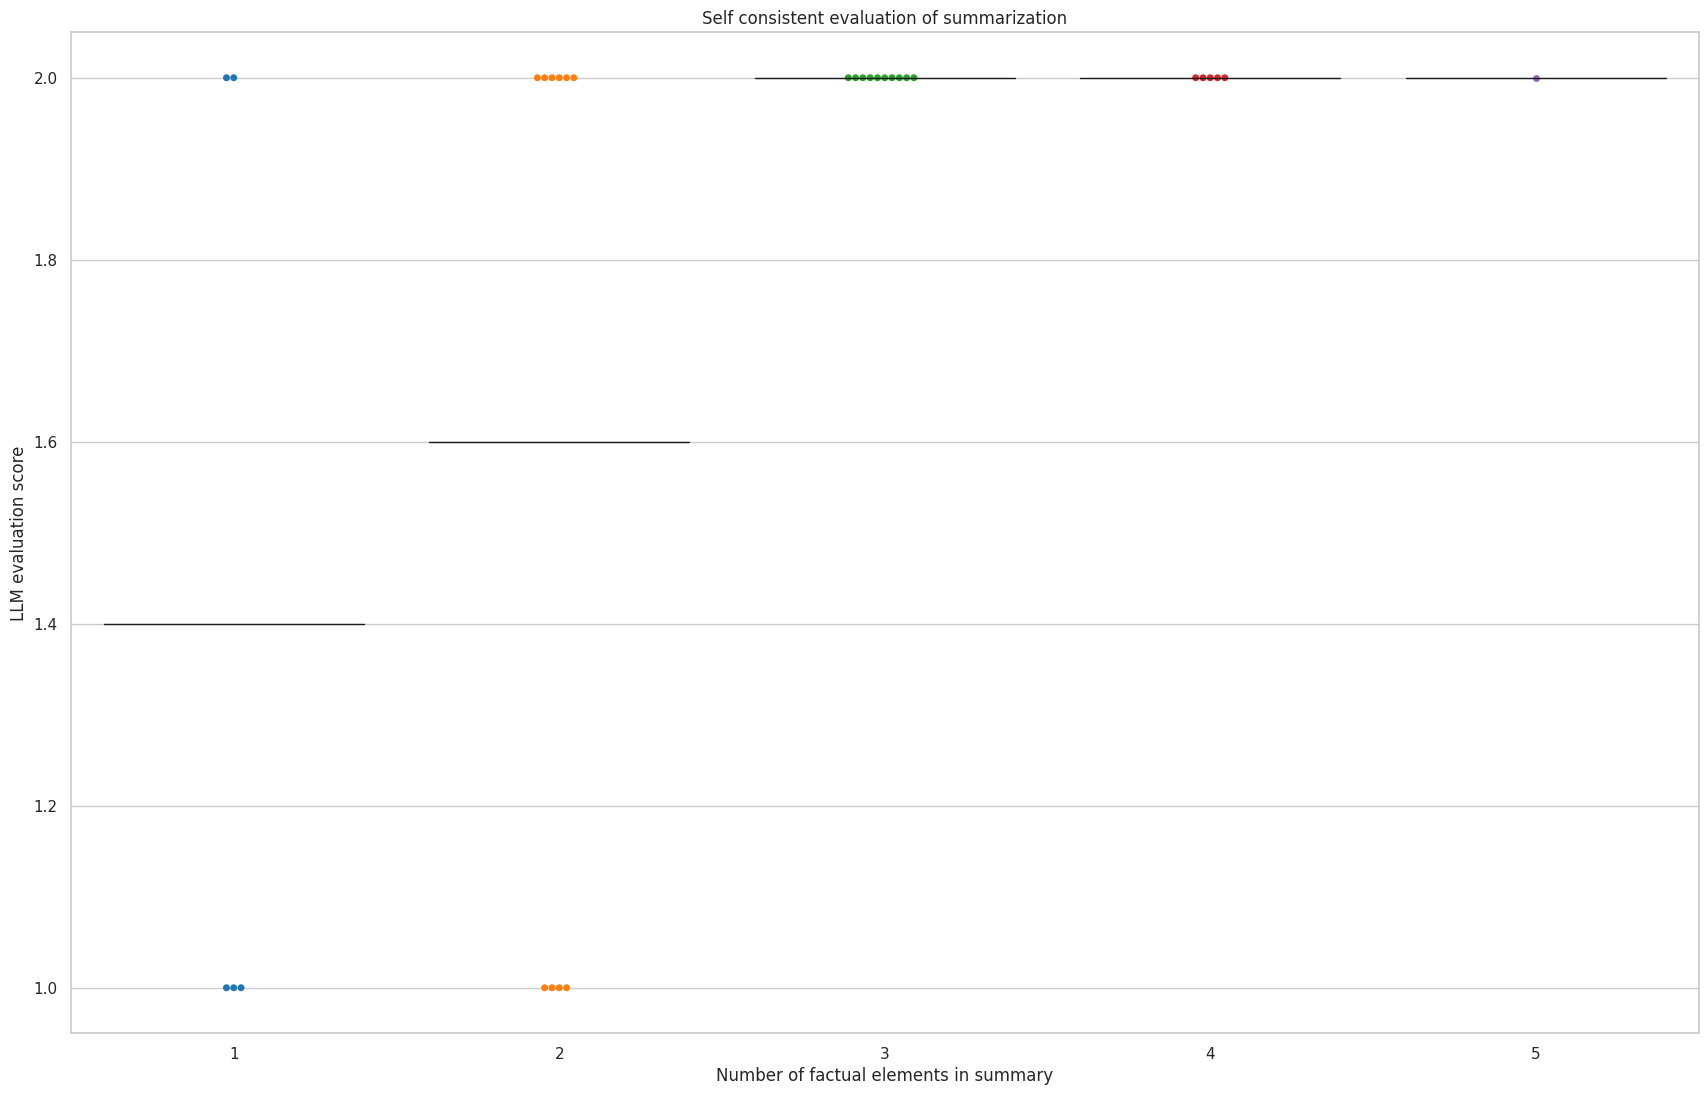

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

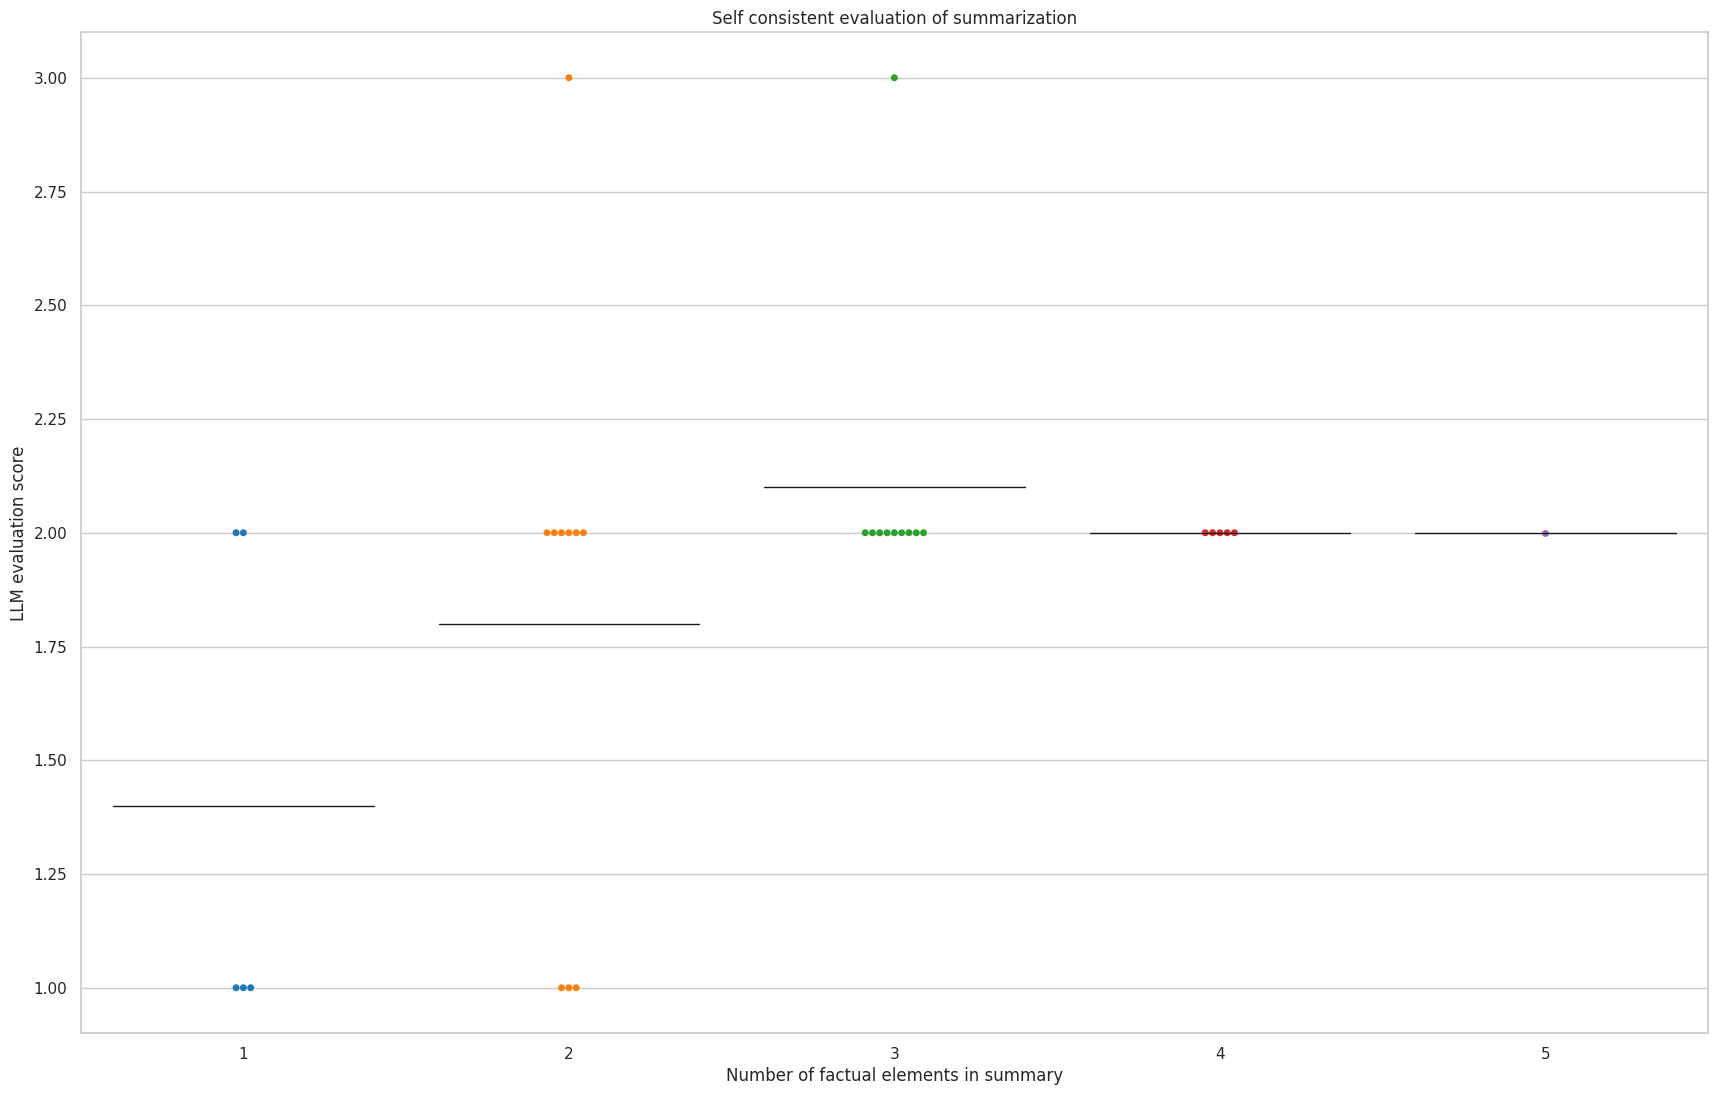

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

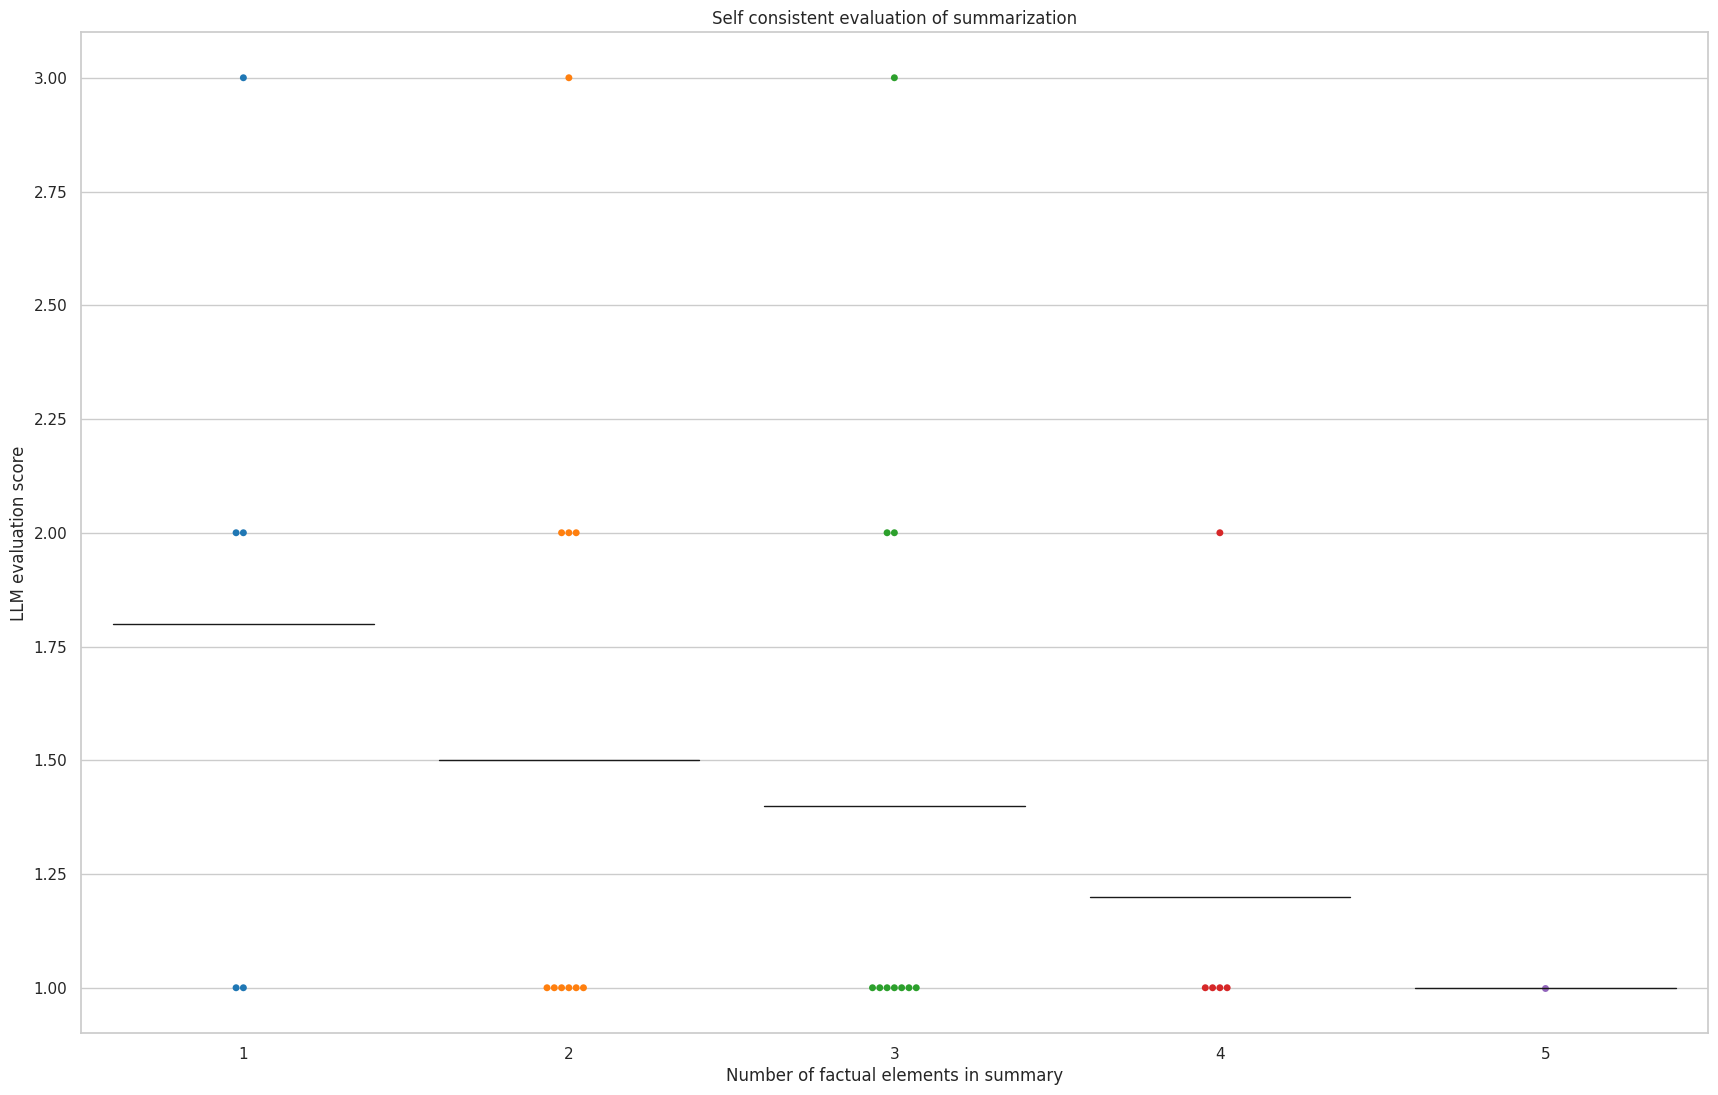

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

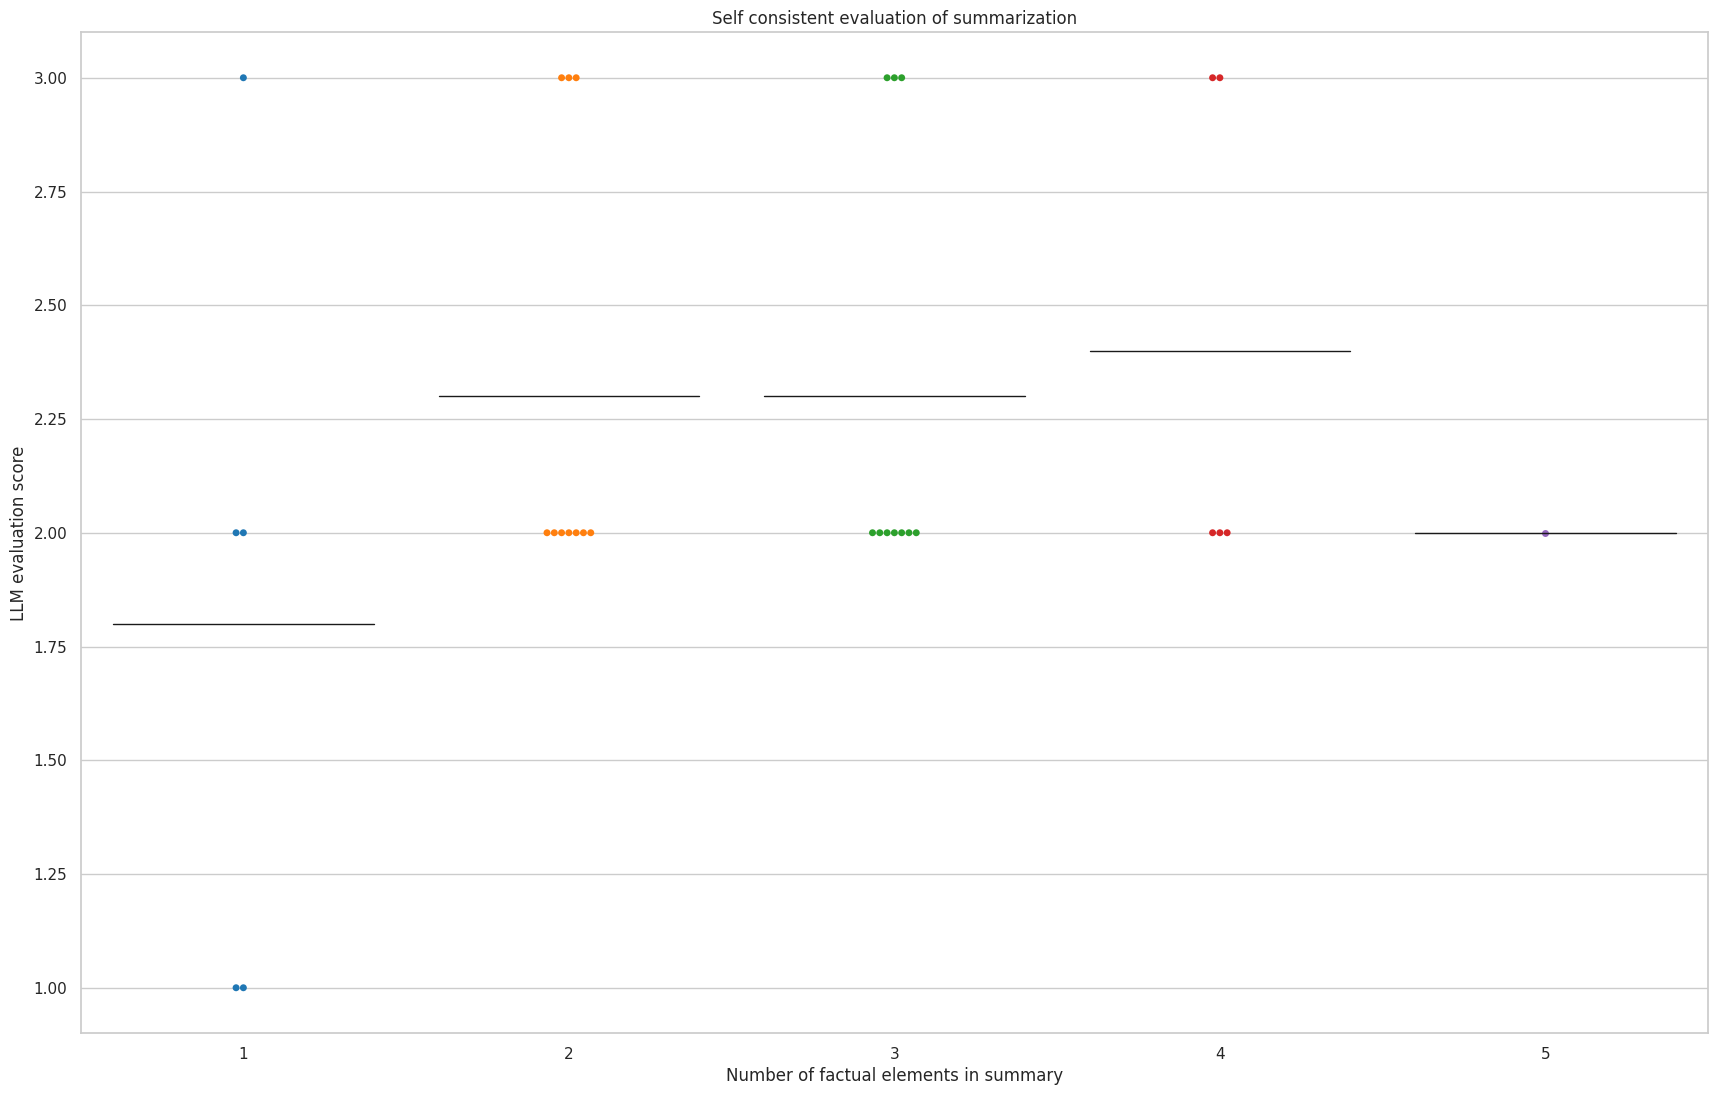

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

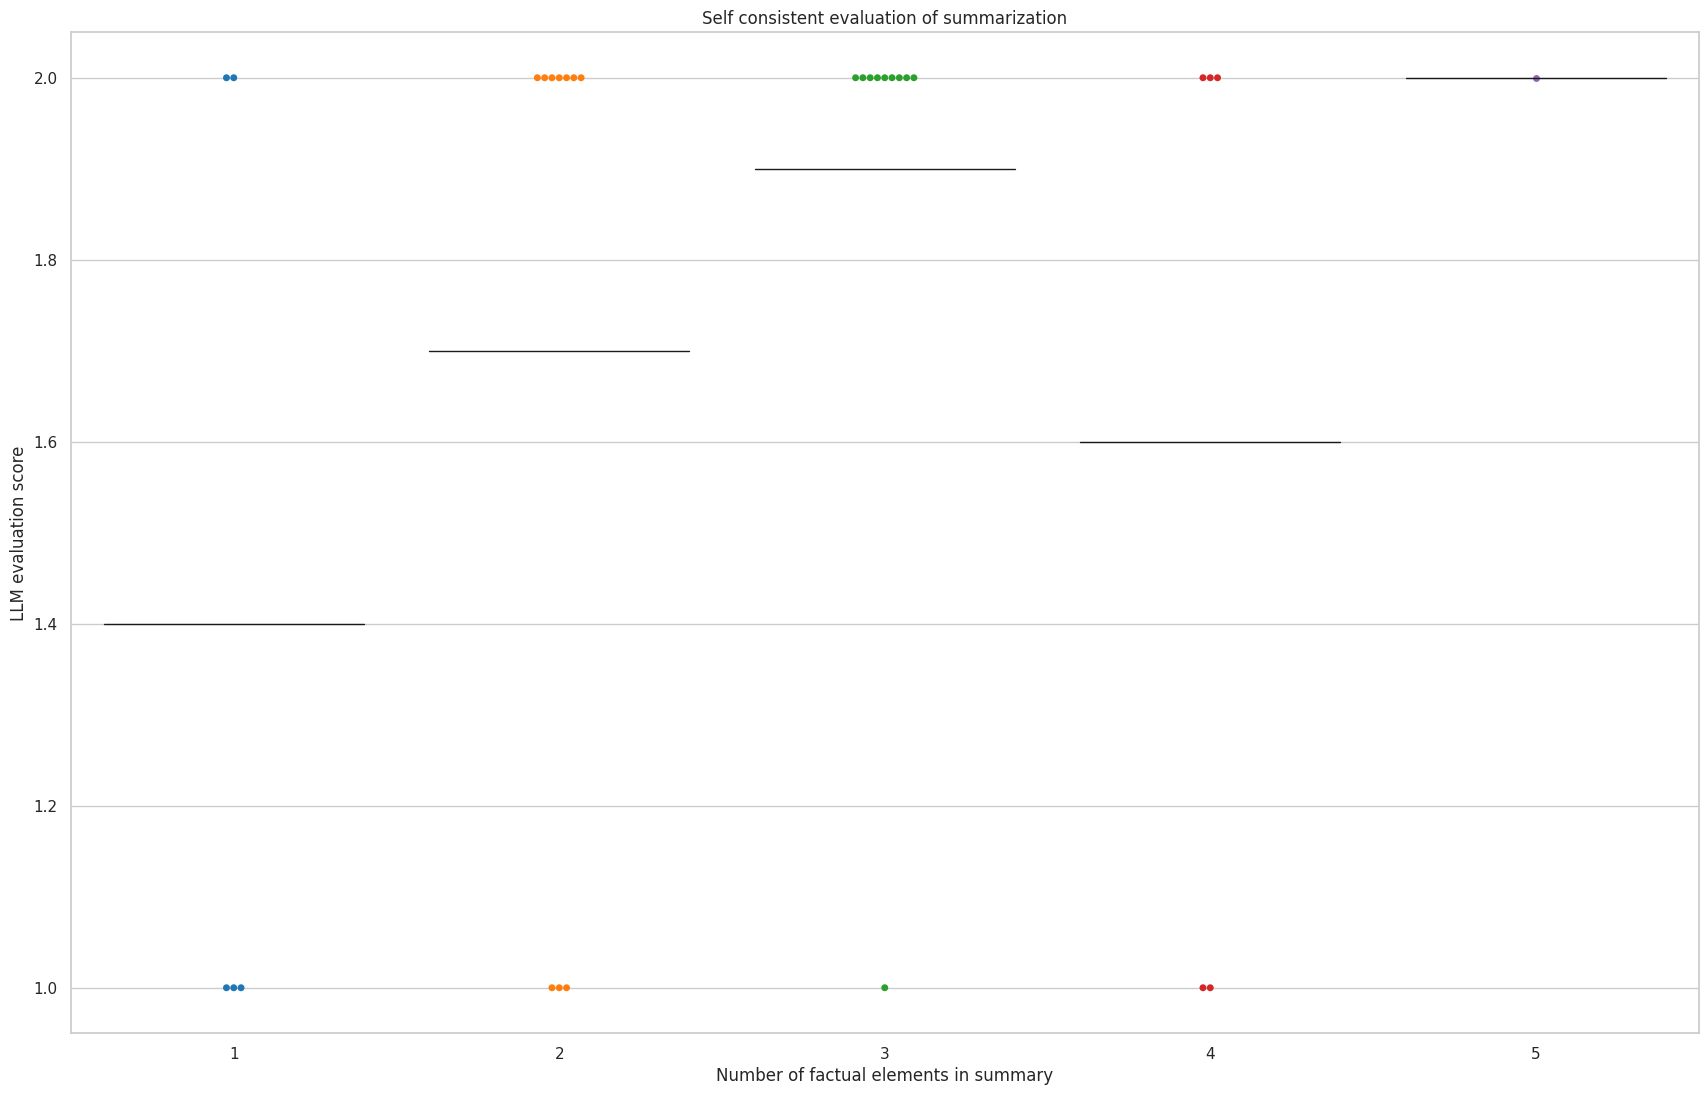

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

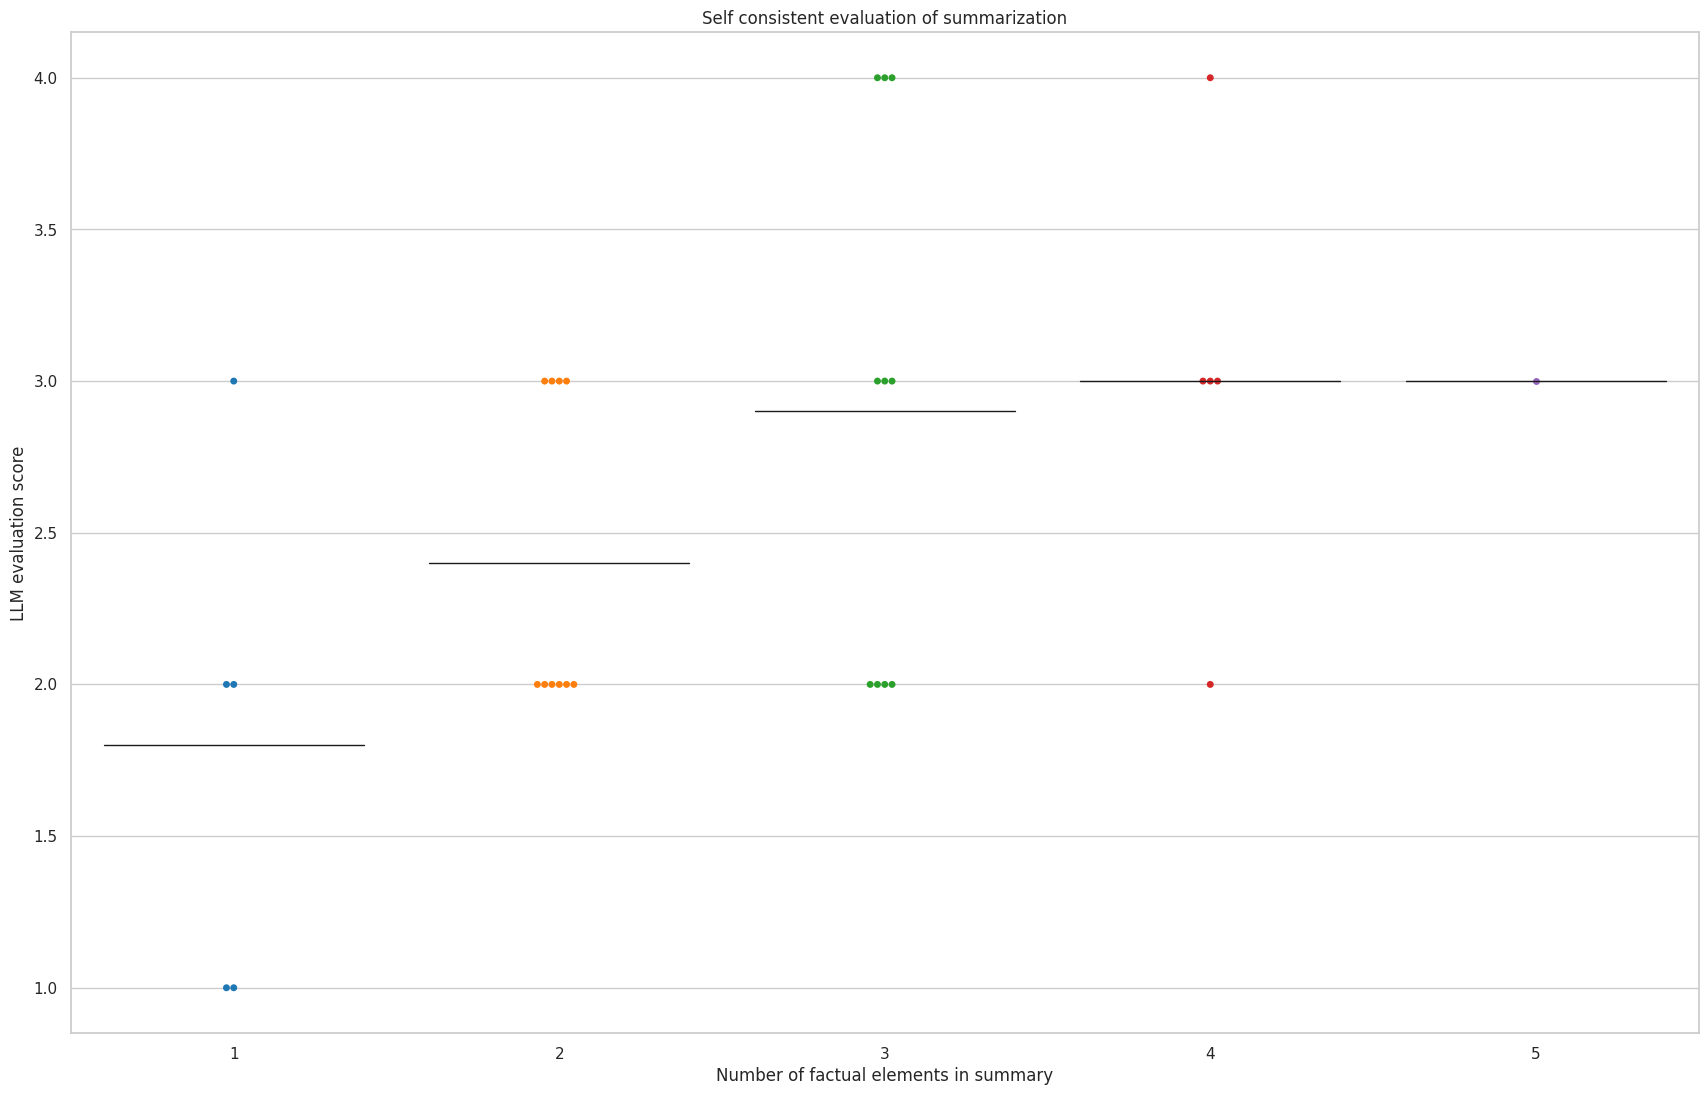

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

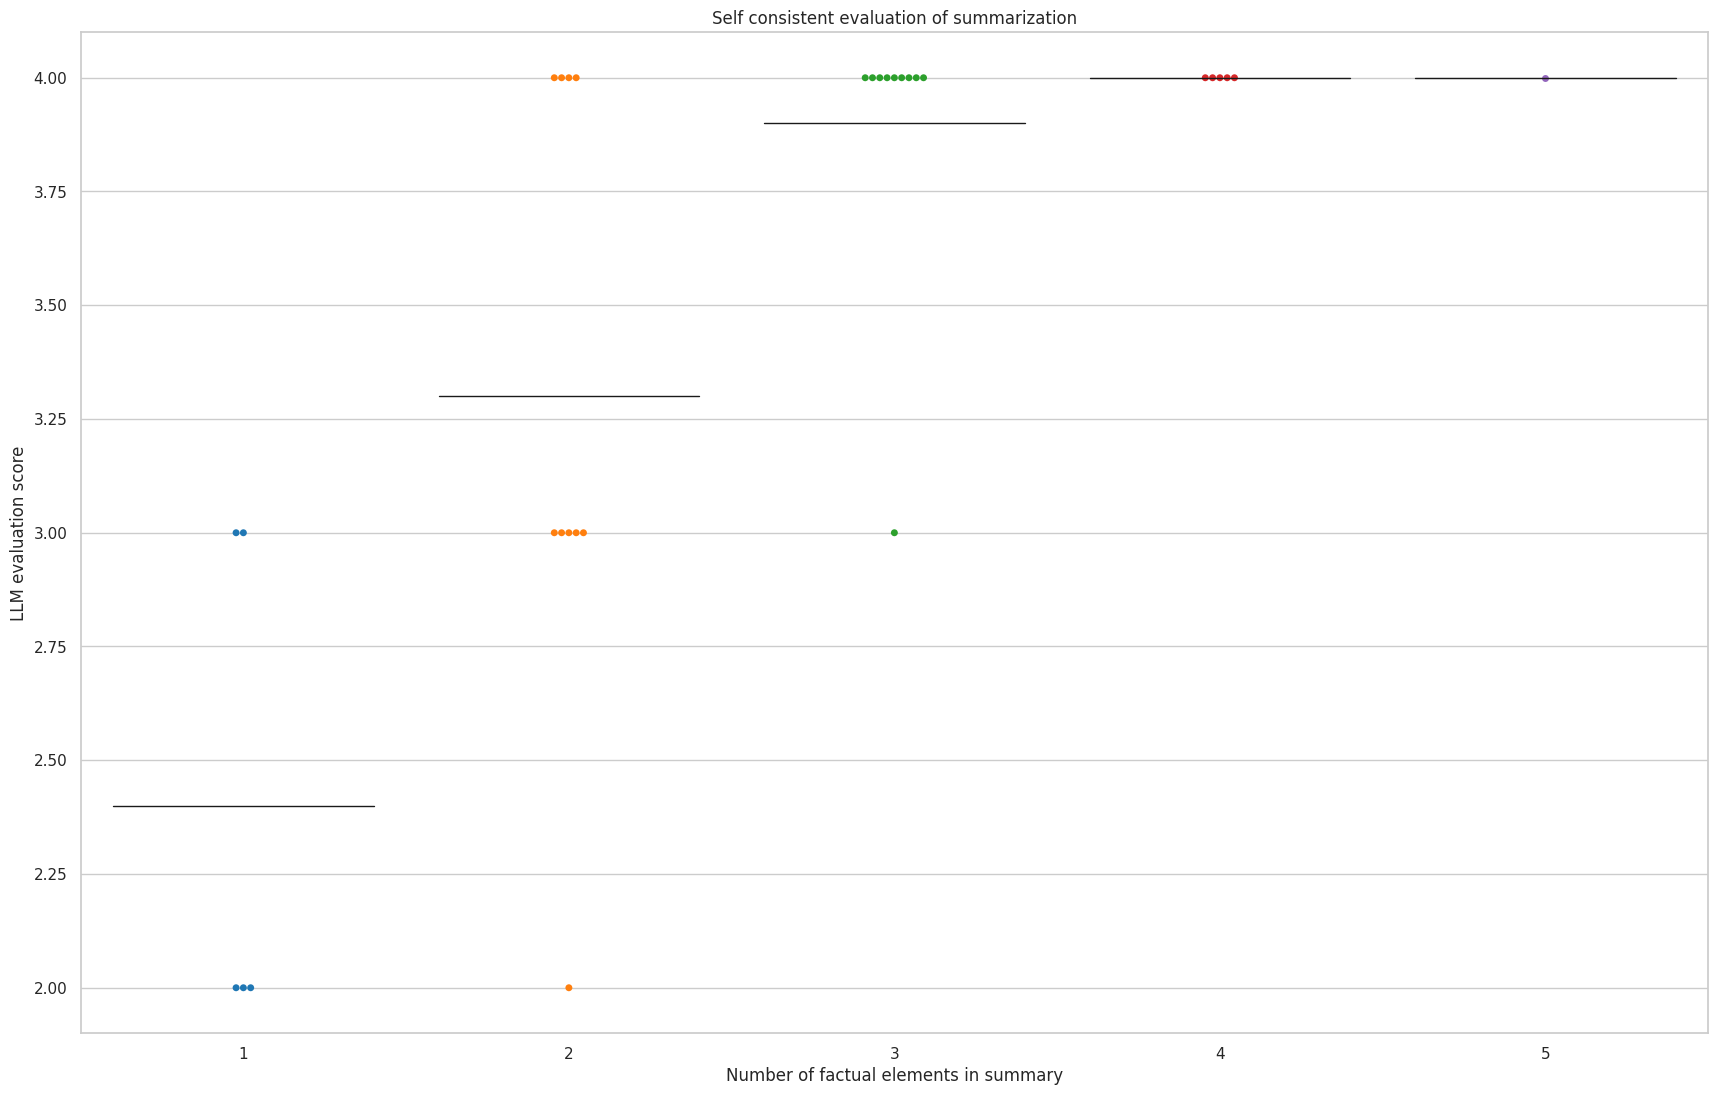

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

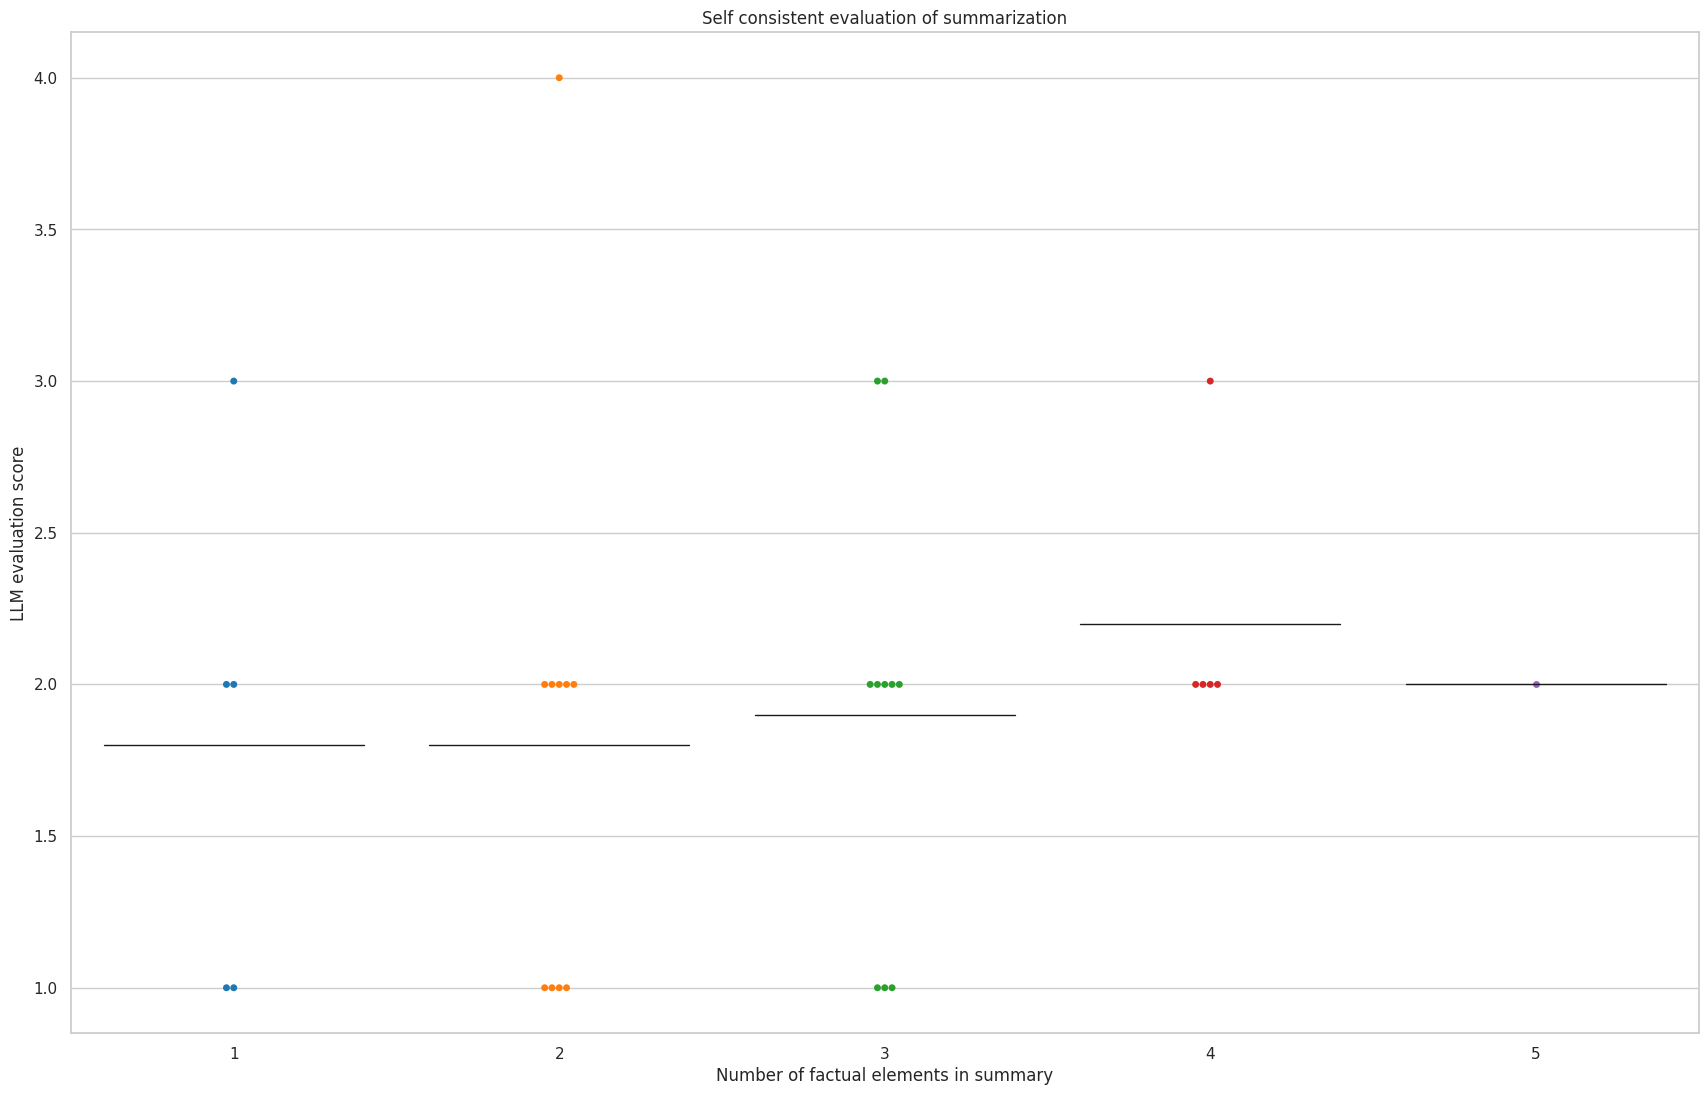

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

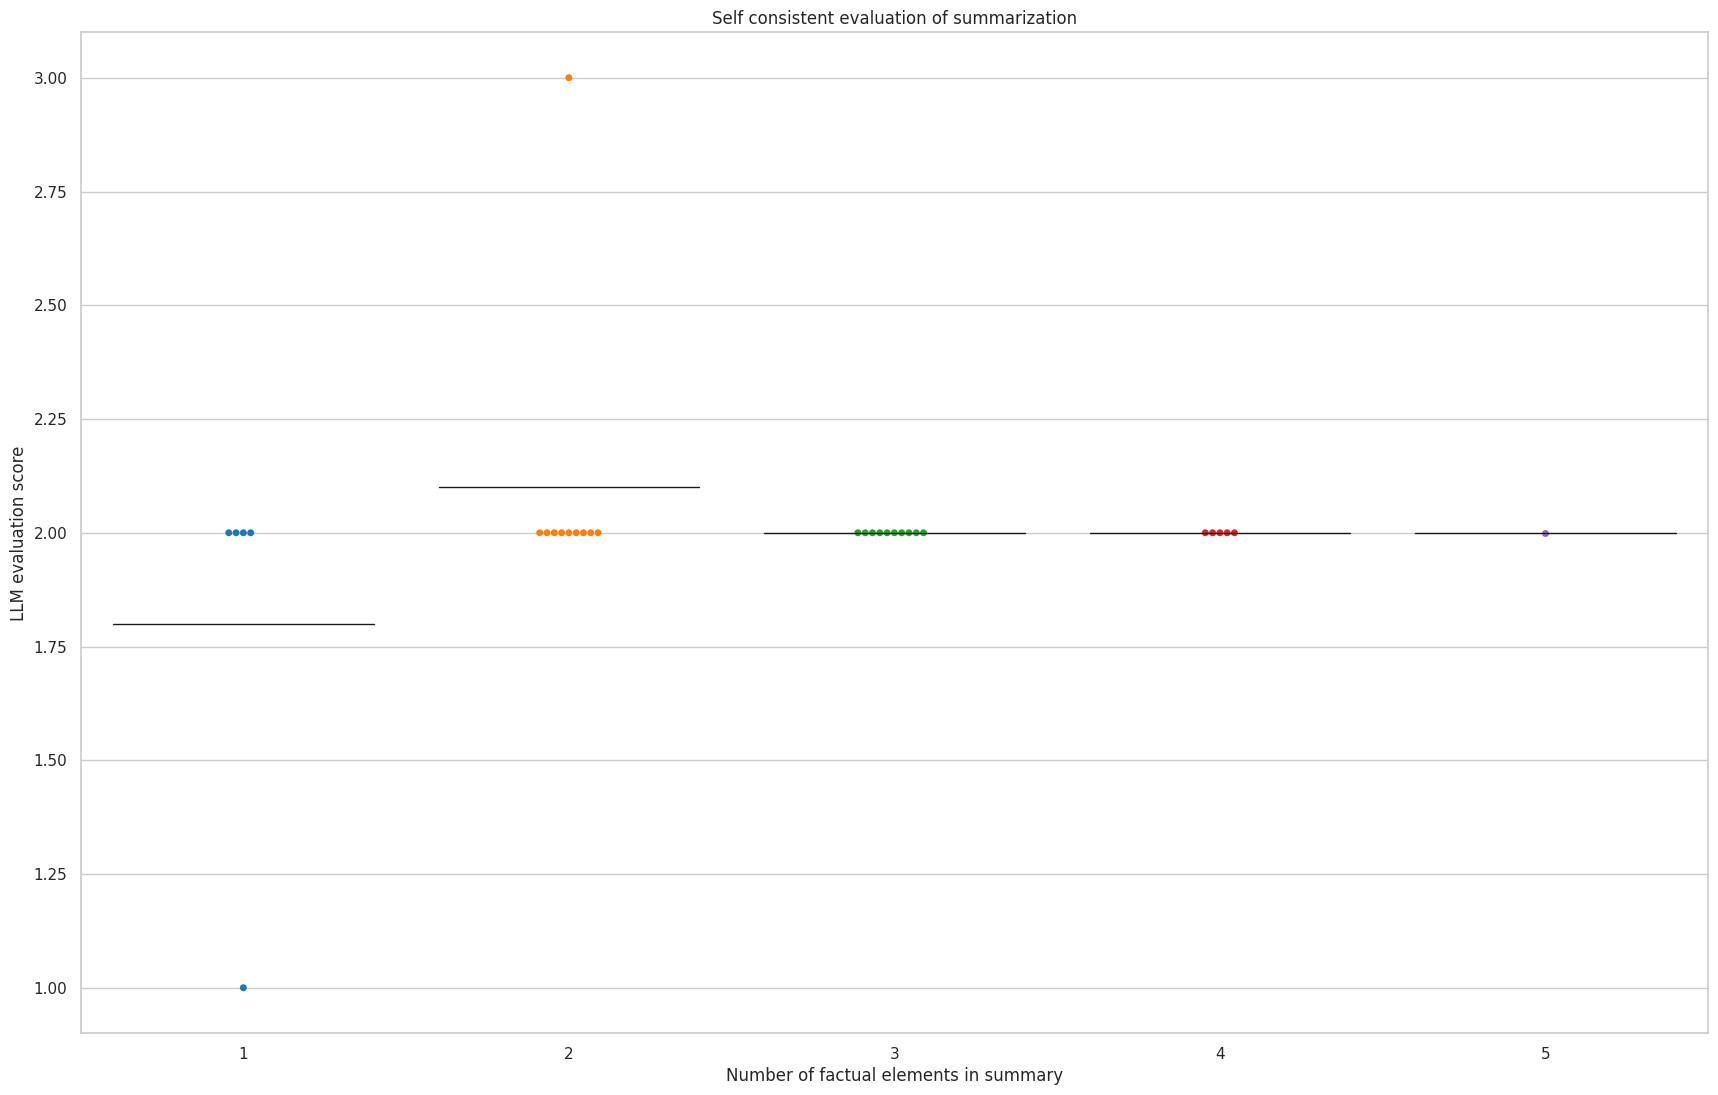

/tmp/ipykernel_808/3077987520.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

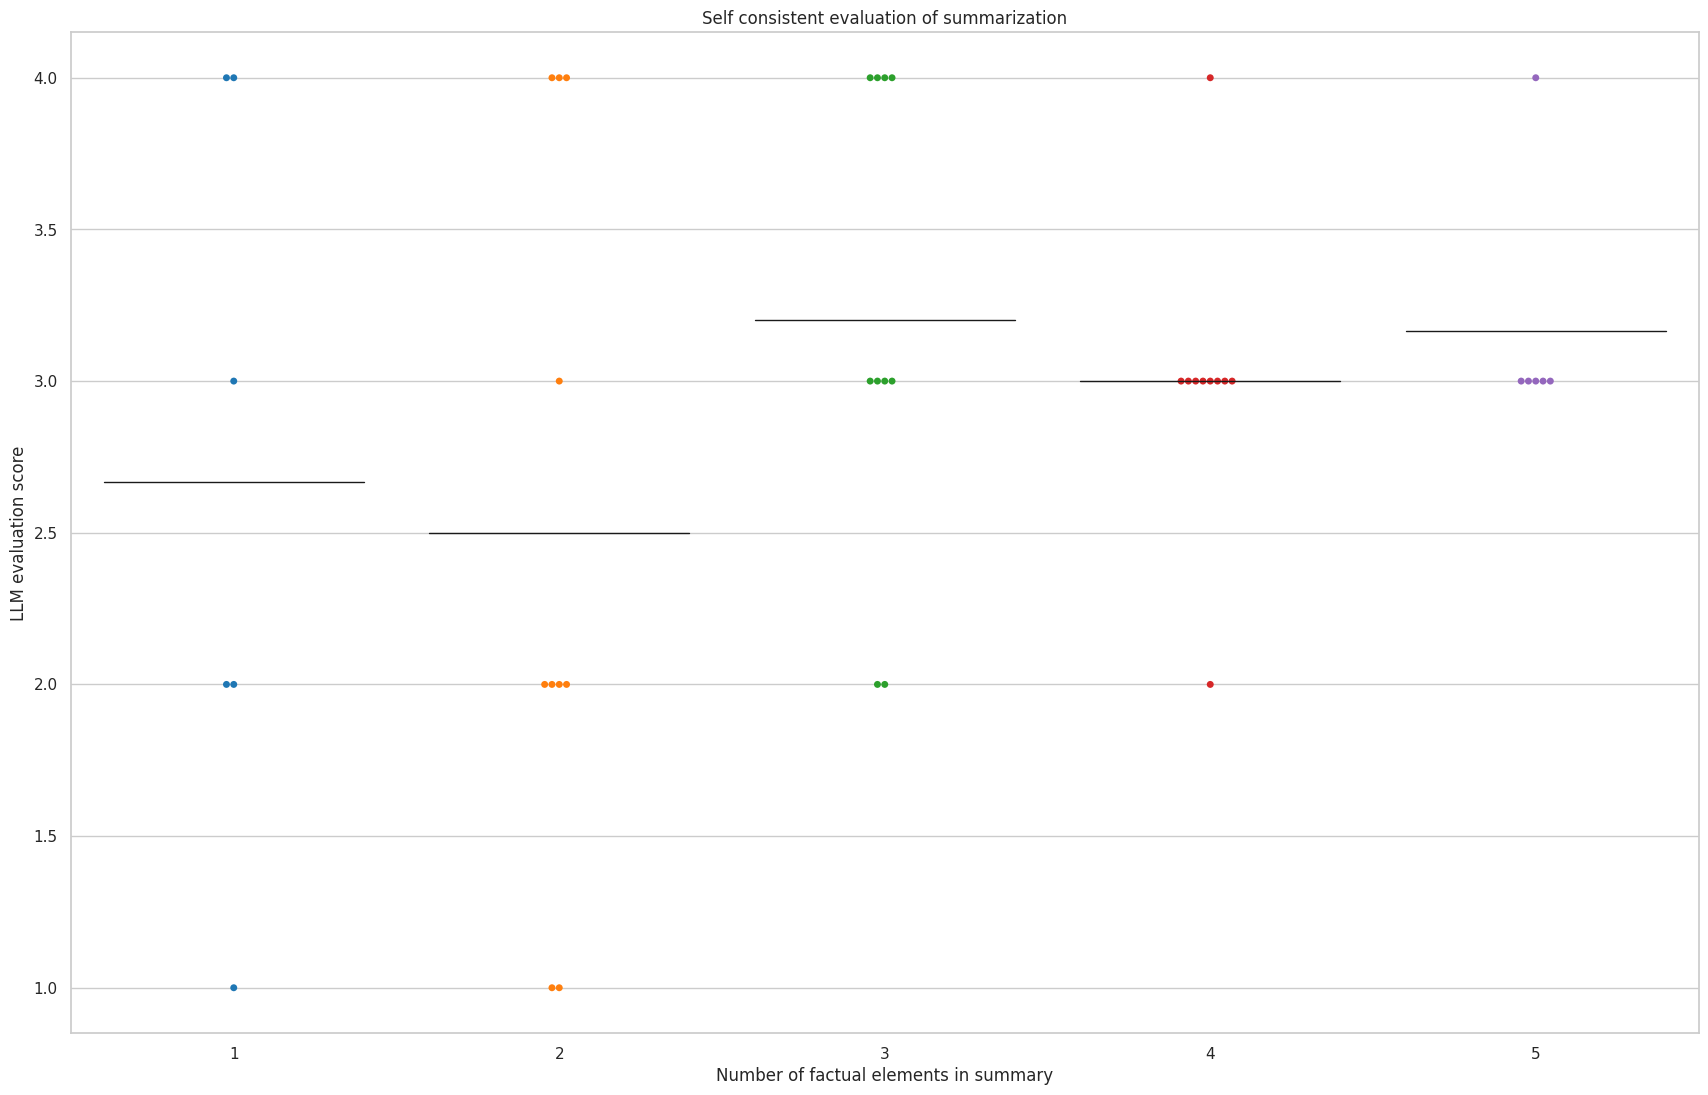

In [121]:
for experiment in incorrect_summary_experiment_results["experiments"]:
    df = pd.DataFrame(experiment["results"])
    df["score"] = df.apply(get_score_to_int, axis=1)
    simple_df = df[["num_facts", "score"]]
    #display(simple_df.head())
    sns.set(style='whitegrid')

    # Code from:
    # https://stackoverflow.com/questions/67481900/how-to-add-a-mean-line-to-a-seaborn-stripplot-or-swarmplot
    # note: need to adjust size if have more points else they don't fit in swarmplot O_o
    plt.figure(figsize=(21, 13))
    p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")

    ax=sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 1},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="num_facts",
                y="score",
                data=simple_df,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)

    plt.title('Self consistent evaluation of summarization')
    ax.set_ylabel("LLM evaluation score")
    ax.set_xlabel("Number of factual elements in summary")
    plt.show()